# Galaxy Morphology Classification with Convolutional Neural Networks
### Author: Gabriel Rocha Pinto - 730676/2025

#### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import os
import re
import itertools
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
%pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras import layers, models
%pip install optuna
import optuna
from functools import partial

Note: you may need to restart the kernel to use updated packages.


2025-12-07 08:53:01.446770: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Note: you may need to restart the kernel to use updated packages.


/mnt/c/Users/gabri/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Global Parameters

In [2]:
# Original images are 424x424 pixels in size, but to ensure better performance and storage capacity during training,
# images will be resized to IMG_SIZE x IMG_SIZE pixels when uploaded
IMG_SIZE = 150
BATCH_SIZE = 16
MAX_EPOCHS = 150 # Maximum number of epochs for training
SEED = 8 # Random seed for reproducibility
K_FOLDS = 3 # Number of folds for cross-validation
OPTUNA_TRIALS = 4 # Number of Optuna trials for hyperparameter optimization

IMAGES_PATH = None # Folder with .jpg images
FILEMAPPING_PATH = None # File mapping images to their respective IDs
LABELS_PATH = None # File with labels
GZ2_CLASS_COLUMN = None # Column name for the gz2 class labels
MAX_SAMPLES = None  # Set to None to load all images
DF_LABELS = None # DataFrame with labels
DF_MAPPING = None # DataFrame with file mapping

### Images and mapping file dataset download
It can be found either in https://zenodo.org/records/3565489 or https://www.kaggle.com/datasets/jaimetrickz/galaxy-zoo-2-images

In [3]:
# This flag allows you to choose between downloading the dataset from Kaggle or directly from Zenodo
download_from_zenodo = False

if not download_from_zenodo:
  %pip install kagglehub
  # Usando o kaggle
  import kagglehub
  output_path = kagglehub.dataset_download("jaimetrickz/galaxy-zoo-2-images")
else:
  # Diretamento do zenodo
  output_path = "downloads"
  %pip install zenodo-get
  !zenodo_get "10.5281/zenodo.3565489" -o "downloads"

print("Path to dataset files:", output_path)

IMAGES_PATH = os.path.join(output_path, "images_gz2", "images")
FILEMAPPING_PATH = os.path.join(output_path, "gz2_filename_mapping.csv")

assert os.path.isdir(IMAGES_PATH), "Directory containing images not found."
assert os.path.isfile(FILEMAPPING_PATH), "Mapping file not found."

Note: you may need to restart the kernel to use updated packages.
Path to dataset files: /home/gabri/.cache/kagglehub/datasets/jaimetrickz/galaxy-zoo-2-images/versions/1


### Classification labels download

It can be found in https://data.galaxyzoo.org/

In this project i will work with the "Table 5 - Main sample, spectroscopic redshifts" since it contains "the largest number of galaxies and the most reliable morphologies".

The description of the data can be found on: https://data.galaxyzoo.org/data/gz2/zoo2MainSpecz.txt

In [4]:
LABELS_PATH = "https://zooniverse-data.s3.amazonaws.com/galaxy-zoo-2/zoo2MainSpecz.csv.gz"
GZ2_CLASS_COLUMN = "gz2class"

# Alternatively, you can use the "Table 1 - Normal-depth sample with new debiasing method" that is
# described in this paper: https://academic.oup.com/mnras/article/461/4/3663/2608720?login=false
# Also, the description of this data can be found on: https://gz2hart.s3.amazonaws.com/gz2_hart16.txt
# LABELS_PATH = "https://gz2hart.s3.amazonaws.com/gz2_hart16.csv.gz"
# GZ2_CLASS_COLUMN = "gz2_class"

### Loading and exploring classification labels


DataFrame shape: (243500, 233)
Number of galaxies: 243500

First columns:
['specobjid', 'dr8objid', 'dr7objid', 'ra', 'dec', 'rastring', 'decstring', 'sample', 'gz2class', 'total_classifications', 'total_votes', 't01_smooth_or_features_a01_smooth_count', 't01_smooth_or_features_a01_smooth_weight', 't01_smooth_or_features_a01_smooth_fraction', 't01_smooth_or_features_a01_smooth_weighted_fraction', 't01_smooth_or_features_a01_smooth_debiased', 't01_smooth_or_features_a01_smooth_flag', 't01_smooth_or_features_a02_features_or_disk_count', 't01_smooth_or_features_a02_features_or_disk_weight', 't01_smooth_or_features_a02_features_or_disk_fraction']

First rows:
      specobjid      dr8objid            dr7objid         ra        dec  \
0  1.802675e+18           NaN  588017703996096547  160.99040  11.703790   
1  1.992984e+18           NaN  587738569780428805  192.41083  15.164207   
2  1.489569e+18           NaN  587735695913320507  210.80220  54.348953   
3  2.924084e+18  1.237668e+18  5877

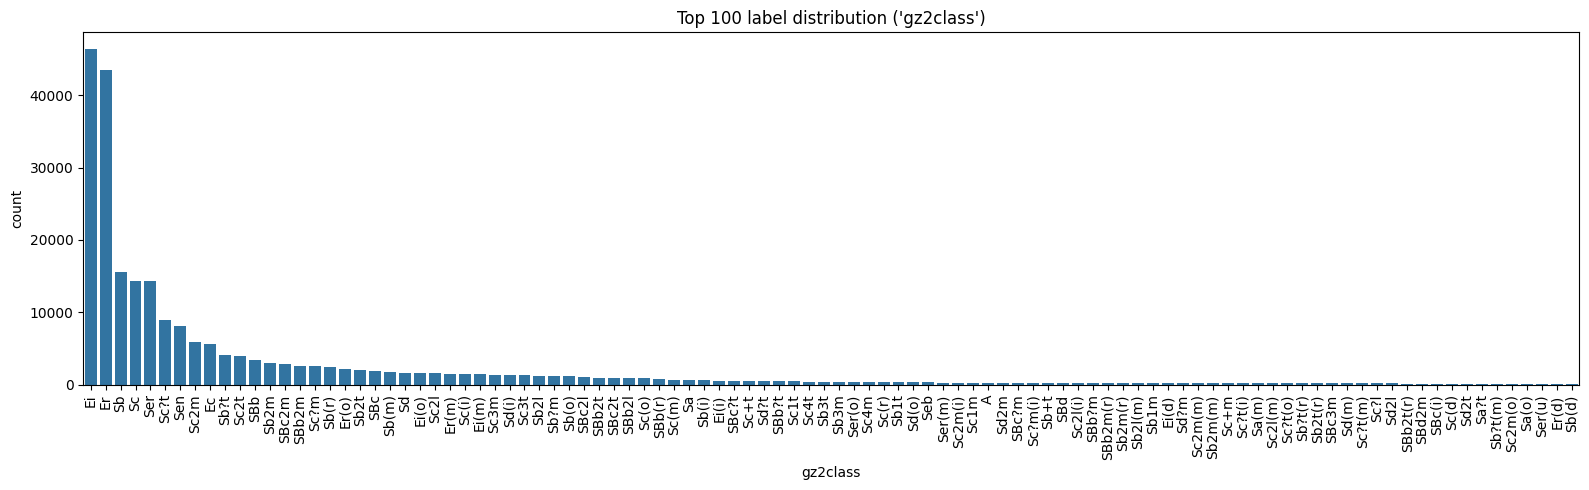

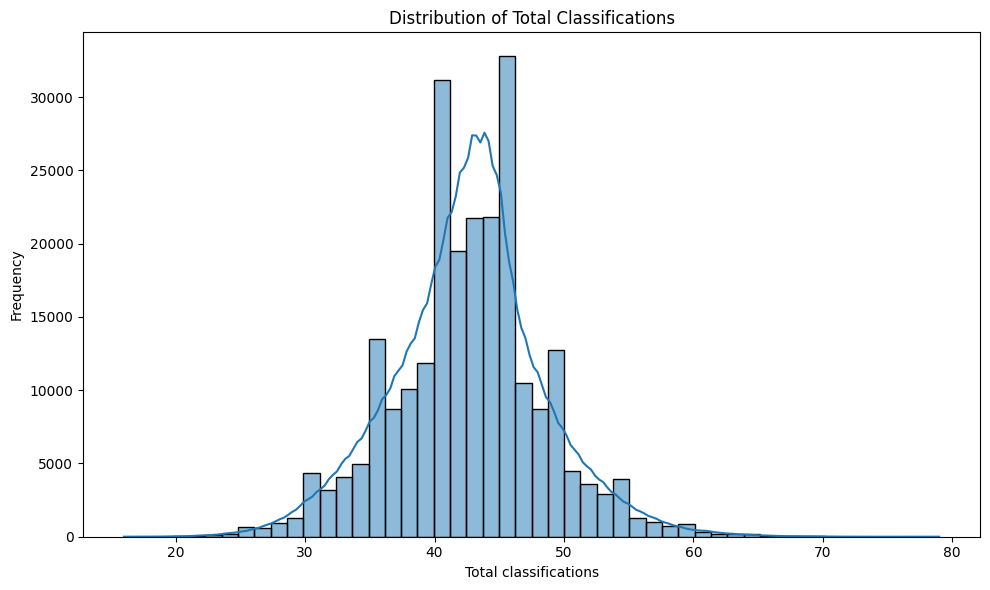

In [5]:
DF_LABELS = pd.read_csv(LABELS_PATH, compression='gzip')

print(f'\nDataFrame shape: {DF_LABELS.shape}')
print(f'Number of galaxies: {len(DF_LABELS)}')
print(f'\nFirst columns:')
print(DF_LABELS.columns[:20].tolist())

print(f'\nFirst rows:')
print(DF_LABELS.head())

# Information about columns
print(f'\nDataset information:')
print(DF_LABELS.info())

# Distribution of labels (column 'gz2class') - show only the top 100 values
print(f'\nNumber of unique classes in {GZ2_CLASS_COLUMN}:', DF_LABELS[GZ2_CLASS_COLUMN].nunique())
print(f'\nLabel distribution ({GZ2_CLASS_COLUMN}) - Top 100:')
top_classes = DF_LABELS[GZ2_CLASS_COLUMN].value_counts().head(100)
print(top_classes)
plt.figure(figsize=(16,5))
sns.countplot(x=GZ2_CLASS_COLUMN, data=DF_LABELS[DF_LABELS[GZ2_CLASS_COLUMN].isin(top_classes.index)], order=top_classes.index)
plt.xticks(rotation=90)
plt.title(f"Top 100 label distribution ('{GZ2_CLASS_COLUMN}')")
plt.tight_layout()
plt.show()

# Histogram of the 'total_classifications' column
plt.figure(figsize=(10, 6))
sns.histplot(DF_LABELS['total_classifications'], bins=50, kde=True)
plt.title('Distribution of Total Classifications')
plt.xlabel('Total classifications')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Loading the file containing the mapping between ID <-> .jpg file

In [6]:
DF_MAPPING = pd.read_csv(FILEMAPPING_PATH)
print(f'\nMapping loaded: {len(DF_MAPPING)} entries')
print(f'Columns: {DF_MAPPING.columns.tolist()}')
print(f'\nFirst rows:')
print(DF_MAPPING.head(5))


Mapping loaded: 355990 entries
Columns: ['objid', 'sample', 'asset_id']

First rows:
                objid    sample  asset_id
0  587722981736120347  original         1
1  587722981736579107  original         2
2  587722981741363294  original         3
3  587722981741363323  original         4
4  587722981741559888  original         5


### Function to create labels according to the Hubble sequence

The get_labels() function converts the textual annotations in the gz2class column (and other auxiliary columns of the DF_LABELS DataFrame) into numerical labels ready for training, following a specified classification scheme. The galazy zoo 2 decision tree can be found on: https://data.galaxyzoo.org/gz_trees/gz_trees.html. It:

- Supports different schemes (e.g., hubble_simple and hubble_classic) and applies scheme-specific mapping rules.
    - hubble_simple scheme: Only 3 classes: E, S, SB (not including S0 galaxies).
    - hubble_classic scheme: 9 classes: E0, E3, E7, S0, Sa, Sb, Sc, SBa, SBb, SBc.
- Filters unwanted labels (e.g., classes with odd features, edge-on galaxies, or ambiguous cases) by assigning them the label -1.
- Uses debiased probability columns (e.g., t01_*, t04_*, etc.) to help deciding the final class.

The final classes are based on this Hubble Sequence:

![Hubble Sequence](https://upload.wikimedia.org/wikipedia/commons/8/8a/Hubble_sequence_photo.png)

In [7]:
def get_labels(classification_scheme):
    
    print(f'\nCreating labels with scheme: {classification_scheme}')

    if classification_scheme == 'hubble_simple':
        class_names = ['E', 'S', 'SB']
        def map_hubble_detailed(row):
            gz2_cls = str(row[GZ2_CLASS_COLUMN]).strip()

            # If it contains parentheses, discard immediately
            # (r)=ring, (l)=lens/arc, (d)=disturbed, (i)=irregular, (o)=other, (m)=merger, (u)=dust lane
            if "(" in gz2_cls and ")" in gz2_cls:
                return -1

            # Discard er, eb, en (edge-on galaxies) anywhere in the string
            if any(bad in gz2_cls for bad in ("er", "eb", "en")):
                return -1

            # Remove the information about the number of spiral arms
            gz2_cls = re.sub(r"[0-9+?]+", "", gz2_cls)

            if gz2_cls.startswith('E'):
                if (row['t01_smooth_or_features_a01_smooth_debiased'] > 0.975):
                    return 0  # Elíptica
            if (gz2_cls.startswith('Sa') and gz2_cls != 'Sa') or (gz2_cls.startswith('Sb') and gz2_cls != 'Sb') or (gz2_cls.startswith('Sc') and gz2_cls != 'Sc'):
                if (row['t03_bar_a07_no_bar_debiased'] > 0.96 and row['t01_smooth_or_features_a02_features_or_disk_debiased'] > 0.9 and row['t04_spiral_a08_spiral_debiased'] > 0.93):
                    return 1  # Espiral
            if (gz2_cls.startswith('SBa') and gz2_cls != 'SBa') or (gz2_cls.startswith('SBb') and gz2_cls != 'SBb') or (gz2_cls.startswith('SBc') and gz2_cls != 'SBc'):
                if (row['t03_bar_a06_bar_debiased'] > 0.9 and row['t01_smooth_or_features_a02_features_or_disk_debiased'] > 0.8 and row['t04_spiral_a08_spiral_debiased'] > 0.8):
                    return 2  # Espiral com barra

            return -1  # Invalid
        DF_LABELS['Hubble_Class'] = DF_LABELS.apply(map_hubble_detailed, axis = 1)
        labels = DF_LABELS['Hubble_Class'].values
    elif classification_scheme == 'hubble_classic':
        class_names = ['E0', 'E3', 'E7', 'S0', 'Sa', 'Sb', 'Sc', 'SBa', 'SBb', 'SBc']
        def map_hubble_classic(row):
            gz2_cls = str(row[GZ2_CLASS_COLUMN]).strip()

            # If it contains parentheses, discard immediately
            # (r)=ring, (l)=lens/arc, (d)=disturbed, (i)=irregular, (o)=other, (m)=merger, (u)=dust lane
            if "(" in gz2_cls and ")" in gz2_cls:
                return -1

            # Discard er, eb, en (edge-on galaxies) anywhere in the string
            # Also discard spiral galaxies with undertemined number of arms indicated by '?'
            if any(bad in gz2_cls for bad in ("er", "eb", "en", "?")):
                return -1

            # Remove the information about the number of spiral arms
            gz2_cls = re.sub(r"[0-9+?]+", "", gz2_cls)

            if (row['t04_spiral_a08_spiral_debiased'] < 0.3):
                if gz2_cls.startswith('Er'):
                    if (row['t07_rounded_a16_completely_round_debiased'] > 0.99):
                        return 0  # E0
                if gz2_cls.startswith('Ei'):
                    if (row['t07_rounded_a17_in_between_debiased'] > 0.973):
                        return 1  # E3
                if gz2_cls.startswith('Ec'):
                    if (row['t07_rounded_a18_cigar_shaped_debiased'] > 0.92):
                        return 2  # E7    
            if gz2_cls == 'Sa' or gz2_cls == 'Sb' or gz2_cls == "SBa" or gz2_cls == "SBb": 
                if (row['t04_spiral_a09_no_spiral_debiased'] > 0.7 and row['t01_smooth_or_features_a01_smooth_debiased'] < 0.19):
                    return 3  # S0
            if gz2_cls.startswith('Sat') or gz2_cls.startswith('Sam') or gz2_cls.startswith('Sal') or gz2_cls.startswith('Sbt'):
                if (row['t05_bulge_prominence_a13_dominant_debiased'] > 0.75 or 
                    (row['t05_bulge_prominence_a12_obvious_debiased'] > 0.55 and row['t10_arms_winding_a28_tight_debiased'] > 0.58)):
                    return 4  # Sa
            if gz2_cls.startswith('Sbm') or gz2_cls.startswith('Sbl') or gz2_cls.startswith('Sbt'):
                if ((row['t05_bulge_prominence_a12_obvious_debiased'] > 0.725 and row['t10_arms_winding_a28_tight_debiased'] <= 0.58)):
                    return 5  # Sb
            if  gz2_cls.startswith('Sct') or gz2_cls.startswith('Scl') or gz2_cls.startswith('Scm'):
                if ((row['t05_bulge_prominence_a11_just_noticeable_debiased'] > 0.83)):
                    return 6  # Sc
            if gz2_cls.startswith('SBat') or gz2_cls.startswith('SBam') or gz2_cls.startswith('SBal') or gz2_cls.startswith('SBbt'):
                if (row['t05_bulge_prominence_a13_dominant_debiased'] > 0.5 or
                    (row['t05_bulge_prominence_a12_obvious_debiased'] > 0.45 and row['t10_arms_winding_a28_tight_debiased'] > 0.4)):
                    return 7  # SBa
            if gz2_cls.startswith('SBbm')  or gz2_cls.startswith('SBbl') or gz2_cls.startswith('SBbt'):
                if (row['t05_bulge_prominence_a12_obvious_debiased'] > 0.65 and row['t10_arms_winding_a28_tight_debiased'] <= 0.4):
                    return 8  # SBb
            if gz2_cls.startswith('SBct') or gz2_cls.startswith('SBcl') or gz2_cls.startswith('SBcm'):
                if ((row['t05_bulge_prominence_a11_just_noticeable_debiased'] > 0.71)):
                    return 9  # SBc

            return -1  # Invalid
        DF_LABELS['Hubble_Class'] = DF_LABELS.apply(map_hubble_classic, axis = 1)
        labels = DF_LABELS['Hubble_Class'].values
    else:
        raise ValueError(f"Unrecognized classification scheme '{classification_scheme}'")
    # Statistics
    print(f'\nClass distribution:')
    unique, counts = np.unique(labels, return_counts=True)
    for cls, count in zip(unique, counts):
        if 0 <= cls < len(class_names):
            print(f'  Class {cls} ({class_names[cls]:5s}): {count:6d} ({count/len(labels)*100:5.1f}%)')
        else:
            # Negative values (e.g. -1) or out-of-range indices are considered discarded/invalid
            print(f'  Class {cls} (Discarded): {count:6d} ({count/len(labels)*100:5.1f}%)')

    num_classes = len(class_names)
    return labels, class_names, num_classes

### Function to create the mapping between the path of the images and their respective labels

The load_labels_mapping() function scans up to MAX_SAMPLES images from the labels generated by the get_labels() function, ignoring the invalid class (-1) and using the DF_MAPPING dataset to generate the final data containing the path of the images and their respective labels for classification.

In [8]:
def load_labels_mapping(labels):

    # Calculate the number of samples to load
    n_samples = len(DF_LABELS) if MAX_SAMPLES is None else min(MAX_SAMPLES, len(DF_LABELS))
    print(f'\nLoading {n_samples} images...')

    image_paths = []
    images = []
    valid_labels = []
    valid_ids = []

    load_success = 0
    invalid_class = 0
    not_in_mapping = 0
    file_not_found = 0
    load_error = 0

    for idx in tqdm(range(n_samples), desc='Carregando'):
        try:
            # Get object ID and label
            obj_id = DF_LABELS.iloc[idx]['dr7objid']
            label = labels[idx]

            # Discard invalid class (-1)
            if label == -1:
                invalid_class += 1
                continue

            # Search filename in mapping
            if obj_id not in DF_MAPPING['objid'].values:
                not_in_mapping += 1
                continue

            # Get the filename from the mapping
            filename = DF_MAPPING.loc[DF_MAPPING['objid'] == obj_id, 'asset_id'].values
            if len(filename) == 0:
                not_in_mapping += 1
                continue
            filename = str(filename[0])
            img_path = os.path.join(IMAGES_PATH, f"{filename}.jpg")

            # Check if the file exists
            if not os.path.exists(img_path):
                file_not_found += 1
                continue

            # If everything is fine, append the new data
            image_paths.append(img_path)
            valid_labels.append(label)
            valid_ids.append(obj_id)
            load_success += 1

        except Exception as e:
            load_error += 1
            print(f"Error loading image {img_path}: {e}")
            continue

    # Convert to numpy arrays
    image_paths = np.array(image_paths)
    images = np.array(images)
    valid_labels = np.array(valid_labels)
    valid_ids = np.array(valid_ids)

    print('Loading results')
    print(f'Successfully loaded: {load_success} images')
    print(f'Invalid class discarded (-1): {invalid_class}')
    print(f'ID not found in mapping: {not_in_mapping}')
    print(f'File not found: {file_not_found}')
    print(f'Error loading: {load_error}')

    return image_paths, valid_labels

### Function for creating train/validation/test datasets

The create_datasets() function is used to divide the data generated by the load_labels_mapping() function into different datasets for train/validation/test.

In addition, a stratified division strategy is used to preserve the proportion of classes in each dataset, avoiding the creation of possible imbalances. This function also undersamples the data from each class to the value provided in the target_samples_per_class argument, so that each class has at most this specified value, in order to ensure balance between classes in some cases and also reduce computational cost. Finally, this function also calculates and returns the weights of each class to be used during training, also aiming to mitigate possible penalties involving unbalanced classes.

In [9]:
def create_datasets(image_paths, labels, class_names, target_samples_per_class=1000):

    # Compute class counts and smallest class size
    unique_classes, counts = np.unique(labels, return_counts=True)
    class_counts = dict(zip(unique_classes, counts))

    # Show class counts before balancing
    print("Class counts before balancing:")
    for cls, count in class_counts.items():
        print(f"  Class {cls} ({class_names[cls]:3s}): {count}")

    print("\nTarget sample size per class:", target_samples_per_class)

    # Undersample classes with count > target_samples_per_class
    undersample_strategy = {int(cls): int(target_samples_per_class) for cls, cnt in zip(unique_classes, counts) if int(cnt) > target_samples_per_class}
    if len(undersample_strategy) > 0:
        print("\nUndersampling strategy (class: target_count):")
        for cls, tgt in undersample_strategy.items():
            print(f"  Class {cls} ({class_names[cls]:3s}): {tgt}")
        rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=SEED)
        X_res, y_res = rus.fit_resample(image_paths.reshape(-1, 1), labels)
    else:
        X_res, y_res = image_paths.reshape(-1, 1), labels
    balanced_paths = X_res.ravel()
    balanced_labels = y_res.astype(int)

    # Show new class counts after balancing
    print("\nDataset after balancing:")
    for cls in np.unique(balanced_labels):
        print(f"  Class {cls} ({class_names[cls]:3s}): {np.sum(balanced_labels == cls)}")

    # Divide the balanced dataset into new training, validation and test sets, in a stratified manner and with the proportion of 70% train, 10% val, 20% test
    temp_paths, test_paths, temp_labels, test_labels= train_test_split(
        balanced_paths, balanced_labels, test_size=0.2, stratify=balanced_labels, random_state=SEED
    )
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.125, stratify=temp_labels, random_state=SEED
    )

    # Total samples in each set
    print("Train Samples:", len(train_paths))
    print("Validation Samples:", len(val_paths))
    print("Test Samples:", len(test_paths))

    # Show the class distribution in the train set
    print("\nClass distribution (Train):")
    unique_train, counts_train = np.unique(train_labels, return_counts=True)
    for cls, count in zip(unique_train, counts_train):
        print(f'  Class {cls} ({class_names[cls]:3s}): {count:6d} ({count/len(train_labels)*100:5.1f}%)')

    # Show the class distribution in the validation set
    print("\nClass distribution (Validation):")
    unique_val, counts_val = np.unique(val_labels, return_counts=True)
    for cls, count in zip(unique_val, counts_val):
        print(f'  Class {cls} ({class_names[cls]:3s}): {count:6d} ({count/len(val_labels)*100:5.1f}%)')

    # Show the class distribution in the test set
    print("\nClass distribution (Test):")
    unique_test, counts_test = np.unique(test_labels, return_counts=True)
    for cls, count in zip(unique_test, counts_test):
        print(f'  Class {cls} ({class_names[cls]:3s}): {count:6d} ({count/len(test_labels)*100:5.1f}%)')

    # Calculate class weights for training set
    print("\nClass Weights for training:")
    train_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    for cls, weight in zip(unique_train, train_weights):
        print(f'  Class {cls} ({class_names[cls]:3s}): {weight}')

    return train_paths, train_labels, val_paths, val_labels, test_paths, test_labels, train_weights

### Function to create datasets compatible with TensorFlow

The create_tf_datasets() function is used to create train/validation/test datasets compatible with TensorFlow from the data returned by the create_datasets() function. In addition, a preprocessing layer is added when loading the images, responsible for reading the images from each path, performing central cropping and resizing to capture only the area of interest (the galaxies are centered in each image) and to make it possible to work with smaller images in order to reduce computational cost, and also to transform the labels that were previously only integers into one-hot encoding vectors (this facilitates the calculation of some metrics during training, such as the F1-Score).

In [10]:
def create_tf_datasets(train_paths, train_labels,
                       val_paths, val_labels,
                       test_paths, test_labels,
                       num_classes,
                       shuffle_buffer=1000, cache=True):

    # This function is used to load and preprocess images, applying the central crop, resizing and one-hot encoding of labels
    def preprocess_image(file_path, label):
        img = tf.io.read_file(file_path)
        # Decode as RGB
        img = tf.image.decode_jpeg(img, channels=3) 
        # Resize using center crop to better focus on the galaxies
        img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE, IMG_SIZE) 
        # Values between [0, 255] that will be normalized in the base model's preprocessing layer
        img = tf.cast(img, tf.float32)  
        # Cast label to int32
        label = tf.cast(label, tf.int32)
        # Transform label to one-hot encoding
        label = tf.one_hot(label, depth=num_classes)
        return img, label

    # Create datasets from arrays/ndarrays of paths and labels
    train_path_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    val_path_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    test_path_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

    # Map processing with parallelism
    train_ds_raw = train_path_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_raw = val_path_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds_raw = test_path_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Apply batch/cache/prefetch and shuffle only for the training set
    if cache:
        train_ds = train_ds_raw.shuffle(buffer_size=shuffle_buffer).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
        val_ds = val_ds_raw.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
        test_ds = test_ds_raw.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
    else:
        train_ds = train_ds_raw.shuffle(buffer_size=shuffle_buffer).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        val_ds = val_ds_raw.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        test_ds = test_ds_raw.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

### Function to plot samples per class of a dataset

The show_samples_per_class() function is used to plot a value equal to samples_per_class of each class of a given dataset returned by the create_tf_datasets() function.

In [11]:
def show_samples_per_class(dataset, class_names, samples_per_class=4):

    # Dictionary to store images per class
    samples = {label: [] for label in range(len(class_names))}

    # Unbatch to iterate over individual samples
    for images, labels in dataset.unbatch():  
        # Get the index of the class with the highest probability
        label = np.argmax(labels) 
        if len(samples[label]) < samples_per_class:
            samples[label].append(images.numpy().astype("uint8"))
        # Stop if there are already enough samples for all classes.
        if all(len(samples[l]) >= samples_per_class for l in samples):
            break

    # Plot each sample for each class
    num_classes = len(class_names)
    plt.figure(figsize=(samples_per_class * 3, num_classes * 3))
    for class_idx, imgs in samples.items():
        for i, img in enumerate(imgs):
            ax = plt.subplot(num_classes, samples_per_class, class_idx * samples_per_class + i + 1)
            plt.imshow(img.astype("uint8"))
            plt.title(class_names[class_idx])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

### Function to create models

The build_model() function is used to create models from a base model (along with its preprocessing layer) and various hyperparameters related to the MLP used in the model output to perform classification based on attributes extracted from the CNN used as a basis: number of hidden layers, number of neurons in each hidden layer (this value refers to the first hidden layer, decreasing by a factor of 2 from there), dropout rate, L1, L2, and activation function of all neurons. In addition, a dynamic data augmentation layer is also added for model training, which contains random horizontal and/or vertical flips, as well as random rotation, zoom, and contrast, in order to make the model more robust and reduce the risk of overfitting.

In [12]:
def build_model(base_model_fn, base_model_preprocessing_fn, model_name, num_classes,
                num_layers=2, neurons=64, dropout_rate=0.2, l1_alpha=0.001, l2_alpha=0.001, activation='relu'):

    # Data Augmentation Layer
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.12),
        tf.keras.layers.RandomZoom(0.08),
        tf.keras.layers.RandomContrast(0.12),
    ], name="data_aug")

    # Instantiate base model and preprocessing function
    base_model = base_model_fn()
    base_model_preprocessing = base_model_preprocessing_fn()
    # Freeze the base model
    base_model.trainable = False

    # Input layer
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = data_augmentation(inputs)

    # Use the preprocessing of the CNN used which expects input images in RGB with values from 0-255
    x = base_model_preprocessing(x)

    # Base model
    x = base_model(x, training=False) # Run in inference mode so that batchnorm statistics are not updated

    # New layers on top of the base model for classification
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    for i in range(num_layers):
        x = tf.keras.layers.Dense(int(neurons / (2**i)), activation=activation, kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1_alpha, l2=l2_alpha))(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)  # Multiclass classification

    model = tf.keras.Model(inputs, outputs, name=model_name)

    return model, base_model

### Function to define the objective function for Optuna's hyperparameter search

The objective() function takes into account all hyperparameters used in the build_model() function, namely: number of hidden layers, number of neurons in each hidden layer, dropout rate, L1, L2, and activation function of all neurons. The search space consists of:

- Number of hidden layers: 1, 2
- Number of neurons in each hidden layer: even numbers from 128 to 512
- Dropout rate: 0.2, 0.3, 0.4
- L1: 0.0, 1e-3
- L2: 0.0, 1e-3
- Função de ativação: relu, leaky_relu
- Taxa de aprendizado inicial: floats from 1e-3 to 5e-3, varying on a logarithmic scale

Optuna is used in conjunction with the Stratified K-Fold Cross Validation method, whereby each internal fold performs the initial training of the model (only the MLP layer for classification), as well as the fine-tuning of the entire pre-trained base model.

In [13]:
def optuna_objective(trial, X_data, y_data, KFold_split,
                     base_model_fn, base_model_preprocessing_fn, model_name, num_classes, train_weights):

    # Suggest hyperparameters
    params = {
        'num_layers': trial.suggest_categorical('num_layers', [1, 2]),
        'neurons': trial.suggest_int('neurons', 128, 512, step=2),  # Only even numbers
        'dropout_rate': trial.suggest_categorical('dropout_rate', [0.2, 0.3, 0.4]),
        'l1_alpha': trial.suggest_categorical('l1_alpha', [0.0, 1e-3]),
        'l2_alpha': trial.suggest_categorical('l2_alpha', [0.0, 1e-3]),
        'activation': trial.suggest_categorical('activation', ['relu', 'leaky_relu']),
    }
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 5e-3, log=True)

    # Print the current trial number and parameters
    print(f'\nTrial: {trial.number}, Parameters: {params}, Learning Rate: {learning_rate}')
    
    # Manual Inner Cross-Validation Loop
    scores = []
    for inner_train_idx, inner_val_idx in KFold_split.split(X_data, y_data):
        X_inner_train, X_inner_test = X_data[inner_train_idx], X_data[inner_val_idx]
        y_inner_train, y_inner_test = y_data[inner_train_idx], y_data[inner_val_idx]

        # Division of the train data into train + validation to use EarlyStopping and ReduceLROnPlateau callbacks, using proportion of 90% train and 10% val
        X_inner_train, X_inner_val, y_inner_train, y_inner_val = train_test_split(X_inner_train, y_inner_train, test_size=0.1, shuffle=True, random_state=SEED)

        # Create TensorFlow datasets
        train_ds, val_ds, test_ds = create_tf_datasets(X_inner_train, y_inner_train, X_inner_val, y_inner_val, X_inner_test, y_inner_test, num_classes)

        # Create a fresh model for each inner fold
        model, base_model = build_model(base_model_fn, base_model_preprocessing_fn, model_name, num_classes, **params)

        # Compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=[
                tf.keras.metrics.CategoricalAccuracy(name="acc"),
                tf.keras.metrics.F1Score(name="F1_score", average='macro'),
            ],
        )

        # Callbacks
        callbacks1 = [
            tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=4, restore_best_weights=True, verbose=0),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=0),
        ]

        # Initial training
        history1 = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=MAX_EPOCHS,
            callbacks=callbacks1,
            class_weight=dict(enumerate(train_weights)),
            verbose=0
        )

        # Fine-tune: unfreeze all layers of the backbone and continue training
        # Mark the base_model as trainable and unfreeze all layers
        base_model.trainable = True
        # Recompile with a lower learning rate for fine-tuning
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate / 10.0),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=[
                tf.keras.metrics.CategoricalAccuracy(name="acc"),
                tf.keras.metrics.F1Score(name="F1_score", average='macro'),
            ],
        )
        # Callbacks
        callbacks2 = [
            tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=5, restore_best_weights=True, verbose=0),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=0),
        ]
        # Continue training for fine-tuning
        history2 = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=MAX_EPOCHS,
            initial_epoch=history1.epoch[-1],
            callbacks=callbacks2,
            class_weight=dict(enumerate(train_weights)),
            verbose=0
        )

        # Evaluate on the inner test set
        loss = model.evaluate(test_ds, verbose=0)
        scores.append(loss[0])
        # Print fold results
        print(f'    Fold: {len(scores)}, Loss: {loss[0]}, Accuracy: {loss[1]}, F1_score: {loss[2]}', flush=True)

    # Return the average score across folds
    return np.mean(scores)

### Function to train the final model using the best hyperparameters

The train_final_model() function uses the best hyperparameters found from the optimization using Optuna to train the final model using the final training and validation datasets. The training process also starts by training only the classifier MLP and then training the entire model (including the base model) for fine-tuning. In addition, this function will also save the final trained model in a file based on the name passed through the model_name argument.

In [14]:
def train_final_model(best_params, train_ds, val_ds,
                      base_model_fn, base_model_preprocessing_fn, model_name, num_classes, train_weights):

    # Separate learning_rate from best_params
    final_learning_rate = best_params.pop('learning_rate')

    # Create the final model using the best parameters
    model, base_model = build_model(base_model_fn, base_model_preprocessing_fn, model_name, num_classes, **best_params)

    # Show the model summary
    model.summary()

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=final_learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="acc"),
            tf.keras.metrics.F1Score(name="F1_score", average='macro'),
        ],
    )

    # Callbacks
    callbacks1 = [
        tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=6, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    ]

    # Training the new layers
    print("\nTraining the new layers...")
    history1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=MAX_EPOCHS,
        callbacks=callbacks1,
        class_weight=dict(enumerate(train_weights)),
    )

    # Fine-tune: unfreeze all layers of the backbone and continue training
    # Mark the base_model as trainable and unfreeze all layers
    base_model.trainable = True
    print("Total trainable layers in base_model:", sum(1 for l in base_model.layers if l.trainable))
    # Recompile with a lower learning rate for fine-tuning
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=final_learning_rate/10.0),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="acc"),
            tf.keras.metrics.F1Score(name="F1_score", average='macro'),
        ],
    )
    # Callbacks
    callbacks2 = [
        tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=10, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1),
    ]
    # Continue training for fine-tuning
    history2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=MAX_EPOCHS,
        initial_epoch=history1.epoch[-1],
        callbacks=callbacks2,
    )
    # Concatenate histories for later plotting
    for k in history1.history.keys():
        history1.history[k] = history1.history[k] + history2.history.get(k, [])
    history = history1

    # Training curves plotting function
    def plot_history(h, keys=("loss","val_loss","acc","val_acc")):
        plt.figure(figsize=(6,4))
        for k in keys:
            if k in h.history:
                plt.plot(h.history[k], label=k)
        plt.xlabel("Epoch"); plt.ylabel("Value"); plt.legend(); plt.title("Training/Validation Curves")
        plt.show()

    # Plot the complete training history
    plot_history(history)

    # Export the final model
    final_path = f"./{model_name}.keras"
    model.save(final_path)
    print("Final model saved at:", final_path)

    return model, history, final_path

### Function to evaluate the final trained model

The evaluate_final_model() function is used to evaluate the final trained model obtained through the train_final_model() function on the final test dataset. In addition, this function will also display the model's classification report on the test dataset, as well as the final confusion matrix.

In [15]:
def evaluate_final_model(model_path, test_ds, class_names):

    # Load the model
    try:
        model = tf.keras.models.load_model(model_path)
        print(f"Model loaded successfully: {model_path}")
    except Exception as e:
        print(f"Error loading model {model_path}: {e}")
        model = None # Ensure model is None if loading fails

    if model:
        # Evaluation on the test set
        test_metrics = model.evaluate(test_ds, verbose=0)
        print("\n[Metrics - Test Dataset]")
        for n, v in zip(model.metrics_names, test_metrics):
            print(f"{n}: {v:.4f}")

        # Report and Confusion Matrix based on the test dataset
        # Get true labels and predictions
        y_true = []
        for _, y in test_ds.unbatch():
            # Assuming label_mode="categorical", get the true class index
            y_true.append(tf.argmax(y).numpy())
        y_true = np.array(y_true)

        # Get predictions as class indices
        y_prob = model.predict(test_ds, verbose=0)
        y_pred = np.argmax(y_prob, axis=1) # Get the index of the class with the highest probability

        print("\n[Classification Report - Test Dataset]")
        # Use the class_names from the dataset as target_names
        print(classification_report(y_true, y_pred, target_names=class_names))

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 10)) # Adjust the figure size to improve visibility with more classes
        plt.imshow(cm, cmap="Blues")
        plt.title("Confusion Matrix - Test Dataset")
        # Use class_names for the ticks
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90) # Rotate ticks for easier reading
        plt.yticks(tick_marks, class_names)
        plt.colorbar(); plt.tight_layout()

        # Add annotations to the confusion matrix
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    verticalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.show()

        return test_metrics

    else:
        print("Model not loaded, skipping evaluation and prediction.")
        return None


## Scheme: hubble_simple
- ### Classes: E, S, SB

Generate class labels based on hubble_simple scheme

In [16]:
labels, class_names, num_classes = get_labels('hubble_simple')


Creating labels with scheme: hubble_simple

Class distribution:
  Class -1 (Discarded): 240336 ( 98.7%)
  Class 0 (E    ):   1072 (  0.4%)
  Class 1 (S    ):   1050 (  0.4%)
  Class 2 (SB   ):   1042 (  0.4%)


Get the mapping between each filepath and label

In [17]:
image_paths, valid_labels = load_labels_mapping(labels)


Loading 243500 images...


Carregando: 100%|██████████| 243500/243500 [00:30<00:00, 7878.69it/s]

Loading results
Successfully loaded: 3164 images
Invalid class discarded (-1): 240336
ID not found in mapping: 0
File not found: 0
Error loading: 0


Generate the stratified train/validation/test datasets

In [18]:
train_paths, train_labels, val_paths, val_labels, test_paths, test_labels, train_weights = create_datasets(image_paths, valid_labels, class_names)

Class counts before balancing:
  Class 0 (E  ): 1072
  Class 1 (S  ): 1050
  Class 2 (SB ): 1042

Target sample size per class: 1000

Undersampling strategy (class: target_count):
  Class 0 (E  ): 1000
  Class 1 (S  ): 1000
  Class 2 (SB ): 1000

Dataset after balancing:
  Class 0 (E  ): 1000
  Class 1 (S  ): 1000
  Class 2 (SB ): 1000
Train Samples: 2100
Validation Samples: 300
Test Samples: 600

Class distribution (Train):
  Class 0 (E  ):    700 ( 33.3%)
  Class 1 (S  ):    700 ( 33.3%)
  Class 2 (SB ):    700 ( 33.3%)

Class distribution (Validation):
  Class 0 (E  ):    100 ( 33.3%)
  Class 1 (S  ):    100 ( 33.3%)
  Class 2 (SB ):    100 ( 33.3%)

Class distribution (Test):
  Class 0 (E  ):    200 ( 33.3%)
  Class 1 (S  ):    200 ( 33.3%)
  Class 2 (SB ):    200 ( 33.3%)

Class Weights for training:
  Class 0 (E  ): 1.0
  Class 1 (S  ): 1.0
  Class 2 (SB ): 1.0


Generate the final train/validation/test datasets compatible with tensorflow

In [19]:
train_ds, val_ds, test_ds = create_tf_datasets(train_paths, train_labels,
                                               val_paths, val_labels,
                                               test_paths, test_labels,
                                               num_classes)

I0000 00:00:1765041793.839564  356445 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6100 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


Show some samples from each class

2025-12-06 14:23:14.772957: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


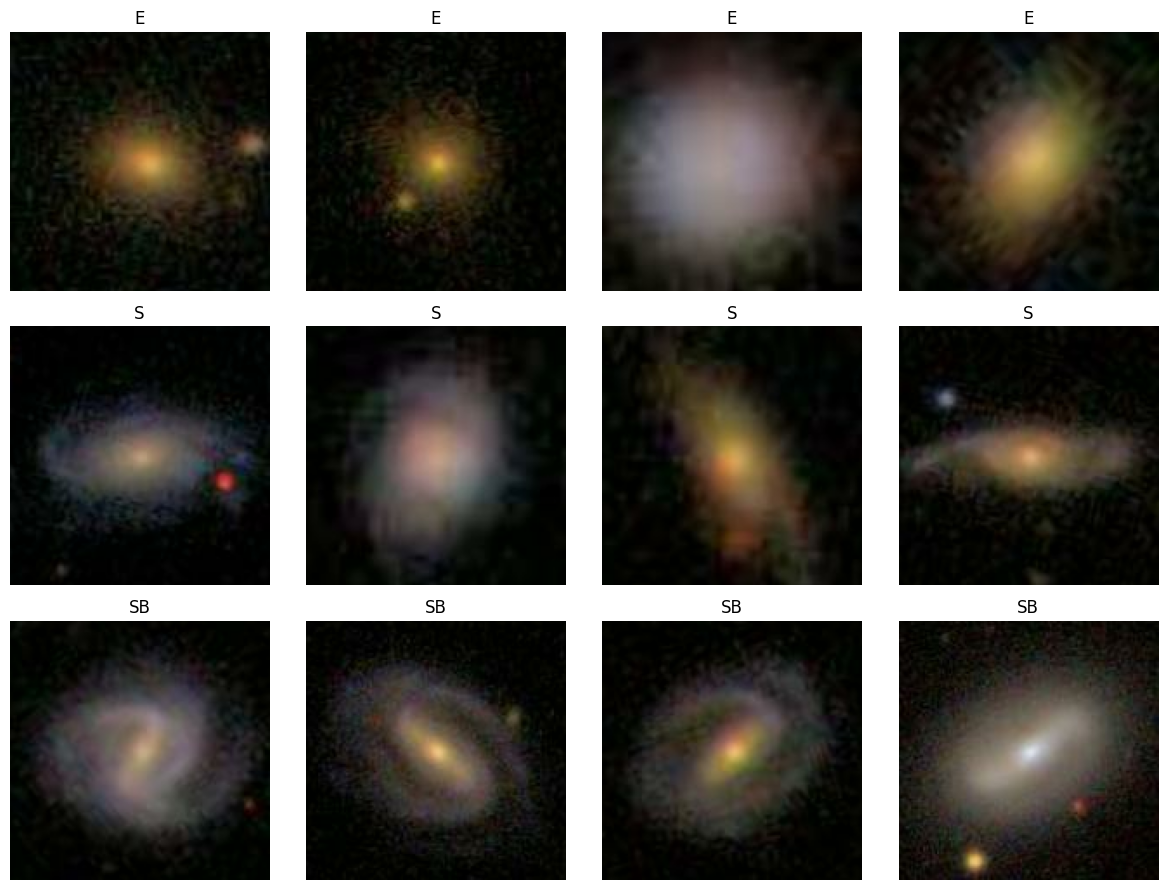

In [20]:
show_samples_per_class(train_ds, class_names, samples_per_class=4)

### Now, two different base models will be tested for the hubble_simple scheme: EfficientNetB3 and ResNet50

### EfficientNetB3

Create the base model using the EfficientNetB3 with pre-trained weights from the ImageNet dataset

In [36]:
efficientnet_base_model_fn = lambda : tf.keras.applications.EfficientNetB3(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False, # Don't include the ImageNet classifier
    weights='imagenet' # Use pre-trained ImageNet weights
)
efficientnet_base_model_preprocessing_fn = lambda : tf.keras.applications.efficientnet.preprocess_input

efficientnet_model_name = "HubbleSimple_EfficientNetB3"

Perform the hyperparameter optimization using optuna

In [37]:
# Set up cross-validation splits
efficientnet_kfold_cv = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

# Create an Optuna study and run the optimization
# The direction is 'minimize' because the loss is being minimized
study = optuna.create_study(direction='minimize')
objective = partial(optuna_objective, X_data = train_paths, y_data = train_labels, KFold_split = efficientnet_kfold_cv,
                    base_model_fn=efficientnet_base_model_fn, base_model_preprocessing_fn=efficientnet_base_model_preprocessing_fn, model_name=efficientnet_model_name,
                    num_classes=num_classes, train_weights=train_weights)
study.optimize(objective, n_trials=OPTUNA_TRIALS) # Set the number of trials for the search
print(f"Best parameters found: {study.best_params}")

[I 2025-12-06 11:29:27,171] A new study created in memory with name: no-name-89cec443-1ac1-48f3-ba66-89e93649d426



Trial: 0, Parameters: {'num_layers': 2, 'neurons': 436, 'dropout_rate': 0.3, 'l1_alpha': 0.001, 'l2_alpha': 0.001, 'activation': 'leaky_relu'}, Learning Rate: 0.0022287901788294205


E0000 00:00:1765031382.615635  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-12-06 11:29:46.824899: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
E0000 00:00:1765031519.059318  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 1, Loss: 0.2382577508687973, Accuracy: 0.9785714149475098, F1_score: 0.9785497784614563


E0000 00:00:1765032134.391955  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1765032255.282014  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 2, Loss: 0.30496153235435486, Accuracy: 0.9614285826683044, F1_score: 0.9615547060966492


E0000 00:00:1765032740.707033  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1765032871.003722  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 3, Loss: 0.3412325978279114, Accuracy: 0.9571428298950195, F1_score: 0.9571318626403809


[I 2025-12-06 12:01:32,805] Trial 0 finished with value: 0.29481729368368786 and parameters: {'num_layers': 2, 'neurons': 436, 'dropout_rate': 0.3, 'l1_alpha': 0.001, 'l2_alpha': 0.001, 'activation': 'leaky_relu', 'learning_rate': 0.0022287901788294205}. Best is trial 0 with value: 0.29481729368368786.



Trial: 1, Parameters: {'num_layers': 1, 'neurons': 200, 'dropout_rate': 0.2, 'l1_alpha': 0.001, 'l2_alpha': 0.0, 'activation': 'relu'}, Learning Rate: 0.001199485725250917


E0000 00:00:1765033309.017329  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1765033488.825664  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 1, Loss: 0.2730232775211334, Accuracy: 0.9457142949104309, F1_score: 0.9455088973045349


E0000 00:00:1765034135.061892  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1765034222.795234  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 2, Loss: 0.6396134495735168, Accuracy: 0.9614285826683044, F1_score: 0.9613525867462158


E0000 00:00:1765034722.005365  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1765034808.592473  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 3, Loss: 0.6265363693237305, Accuracy: 0.9571428298950195, F1_score: 0.9570717811584473


[I 2025-12-06 12:35:04,682] Trial 1 finished with value: 0.513057698806127 and parameters: {'num_layers': 1, 'neurons': 200, 'dropout_rate': 0.2, 'l1_alpha': 0.001, 'l2_alpha': 0.0, 'activation': 'relu', 'learning_rate': 0.001199485725250917}. Best is trial 0 with value: 0.29481729368368786.



Trial: 2, Parameters: {'num_layers': 2, 'neurons': 152, 'dropout_rate': 0.2, 'l1_alpha': 0.0, 'l2_alpha': 0.001, 'activation': 'leaky_relu'}, Learning Rate: 0.0028783905101812638


E0000 00:00:1765035323.931279  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1765035439.266916  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 1, Loss: 0.24601459503173828, Accuracy: 0.9628571271896362, F1_score: 0.9627144932746887


E0000 00:00:1765036022.254286  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1765036152.783793  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 2, Loss: 0.28675755858421326, Accuracy: 0.9571428298950195, F1_score: 0.9571776390075684


E0000 00:00:1765036660.090692  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1765036781.995461  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 3, Loss: 0.24794572591781616, Accuracy: 0.9714285731315613, F1_score: 0.9714550375938416


[I 2025-12-06 13:10:38,273] Trial 2 finished with value: 0.26023929317792255 and parameters: {'num_layers': 2, 'neurons': 152, 'dropout_rate': 0.2, 'l1_alpha': 0.0, 'l2_alpha': 0.001, 'activation': 'leaky_relu', 'learning_rate': 0.0028783905101812638}. Best is trial 2 with value: 0.26023929317792255.



Trial: 3, Parameters: {'num_layers': 1, 'neurons': 158, 'dropout_rate': 0.3, 'l1_alpha': 0.001, 'l2_alpha': 0.0, 'activation': 'relu'}, Learning Rate: 0.003735800946681598


E0000 00:00:1765037451.284394  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1765037556.930814  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 1, Loss: 0.28428658843040466, Accuracy: 0.954285740852356, F1_score: 0.9541084170341492


E0000 00:00:1765037913.866463  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1765038051.734548  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 2, Loss: 0.3303990066051483, Accuracy: 0.9585714340209961, F1_score: 0.95819491147995


E0000 00:00:1765038424.030997  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1765038526.478711  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 3, Loss: 0.18157385289669037, Accuracy: 0.9742857217788696, F1_score: 0.9742971062660217


[I 2025-12-06 13:37:45,130] Trial 3 finished with value: 0.26541981597741443 and parameters: {'num_layers': 1, 'neurons': 158, 'dropout_rate': 0.3, 'l1_alpha': 0.001, 'l2_alpha': 0.0, 'activation': 'relu', 'learning_rate': 0.003735800946681598}. Best is trial 2 with value: 0.26023929317792255.


Best parameters found: {'num_layers': 2, 'neurons': 152, 'dropout_rate': 0.2, 'l1_alpha': 0.0, 'l2_alpha': 0.001, 'activation': 'leaky_relu', 'learning_rate': 0.0028783905101812638}


Train the final model with the best hyperparameters found

Model: "HubbleSimple_EfficientNetB3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_aug (Sequential)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 5, 5, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 152)            │       233,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 152)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 76)             │        11,628 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 76)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 3)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,029,018 (42.07 MB)

 Trainable params: 245,483 (958.92 KB)

 Non-trainable params: 10,783,535 (41.14 MB)


Training the new layers...
Epoch 1/150


E0000 00:00:1765039079.268934  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


132/132 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - F1_score: 0.7195 - acc: 0.7214 - loss: 0.9916 - val_F1_score: 0.8749 - val_acc: 0.8767 - val_loss: 0.6376 - learning_rate: 0.0029
Epoch 2/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - F1_score: 0.8018 - acc: 0.8029 - loss: 0.7505 - val_F1_score: 0.8512 - val_acc: 0.8533 - val_loss: 0.5642 - learning_rate: 0.0029
Epoch 3/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - F1_score: 0.8079 - acc: 0.8090 - loss: 0.6759 - val_F1_score: 0.7541 - val_acc: 0.7733 - val_loss: 0.6482 - learning_rate: 0.0029
Epoch 4/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - F1_score: 0.8042 - acc: 0.8057 - loss: 0.6419 - val_F1_score: 0.8079 - val_acc: 0.8167 - val_loss: 0.5820 - learning_rate: 0.0029
Epoch 5/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - F1_score: 0.8164 - acc: 0.8176 - loss: 0.6046 - val_F1_score: 0.8708 - val_acc: 0.8700 - val_loss: 0.4840 - learning_rate: 0.0029
Epoch 6/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - F1_score: 0.8120 - 

E0000 00:00:1765039212.012982  299971 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleSimple_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


132/132 ━━━━━━━━━━━━━━━━━━━━ 118s 480ms/step - F1_score: 0.7894 - acc: 0.7905 - loss: 0.8302 - val_F1_score: 0.9265 - val_acc: 0.9267 - val_loss: 0.4464 - learning_rate: 2.8784e-04
Epoch 8/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 61s 463ms/step - F1_score: 0.9085 - acc: 0.9086 - loss: 0.5314 - val_F1_score: 0.9568 - val_acc: 0.9567 - val_loss: 0.3674 - learning_rate: 2.8784e-04
Epoch 9/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 62s 466ms/step - F1_score: 0.9314 - acc: 0.9314 - loss: 0.4234 - val_F1_score: 0.9634 - val_acc: 0.9633 - val_loss: 0.3457 - learning_rate: 2.8784e-04
Epoch 10/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 61s 460ms/step - F1_score: 0.9466 - acc: 0.9467 - loss: 0.3708 - val_F1_score: 0.9699 - val_acc: 0.9700 - val_loss: 0.2909 - learning_rate: 2.8784e-04
Epoch 11/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 60s 453ms/step - F1_score: 0.9671 - acc: 0.9671 - loss: 0.3079 - val_F1_score: 0.9833 - val_acc: 0.9833 - val_loss: 0.2692 - learning_rate: 2.8784e-04
Epoch 12/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 60s 455

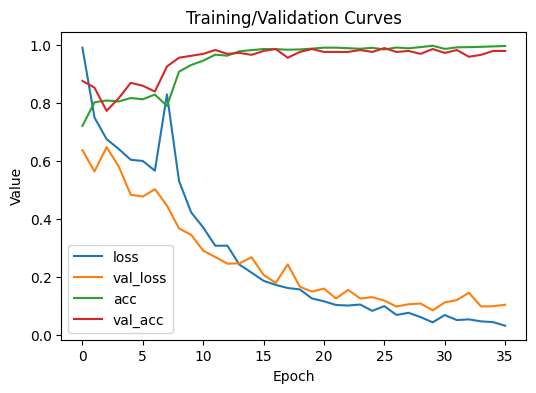

Final model saved at: ./HubbleSimple_EfficientNetB3.keras


In [38]:
best_params = study.best_params

efficientnet_final_model, efficientnet_history, efficientnet_final_model_path = train_final_model(best_params, train_ds, val_ds,
                                                                                                  efficientnet_base_model_fn, efficientnet_base_model_preprocessing_fn, efficientnet_model_name,
                                                                                                  num_classes, train_weights)

Evaluate the final model trained with the best hyperparameters

Model loaded successfully: ./HubbleSimple_EfficientNetB3.keras

[Metrics - Test Dataset]
loss: 0.1889
compile_metrics: 0.9650


2025-12-06 14:10:41.726146: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



[Classification Report - Test Dataset]
              precision    recall  f1-score   support

           E       0.96      0.99      0.98       200
           S       0.96      0.96      0.96       200
          SB       0.98      0.94      0.96       200

    accuracy                           0.96       600
   macro avg       0.97      0.96      0.96       600
weighted avg       0.97      0.96      0.96       600



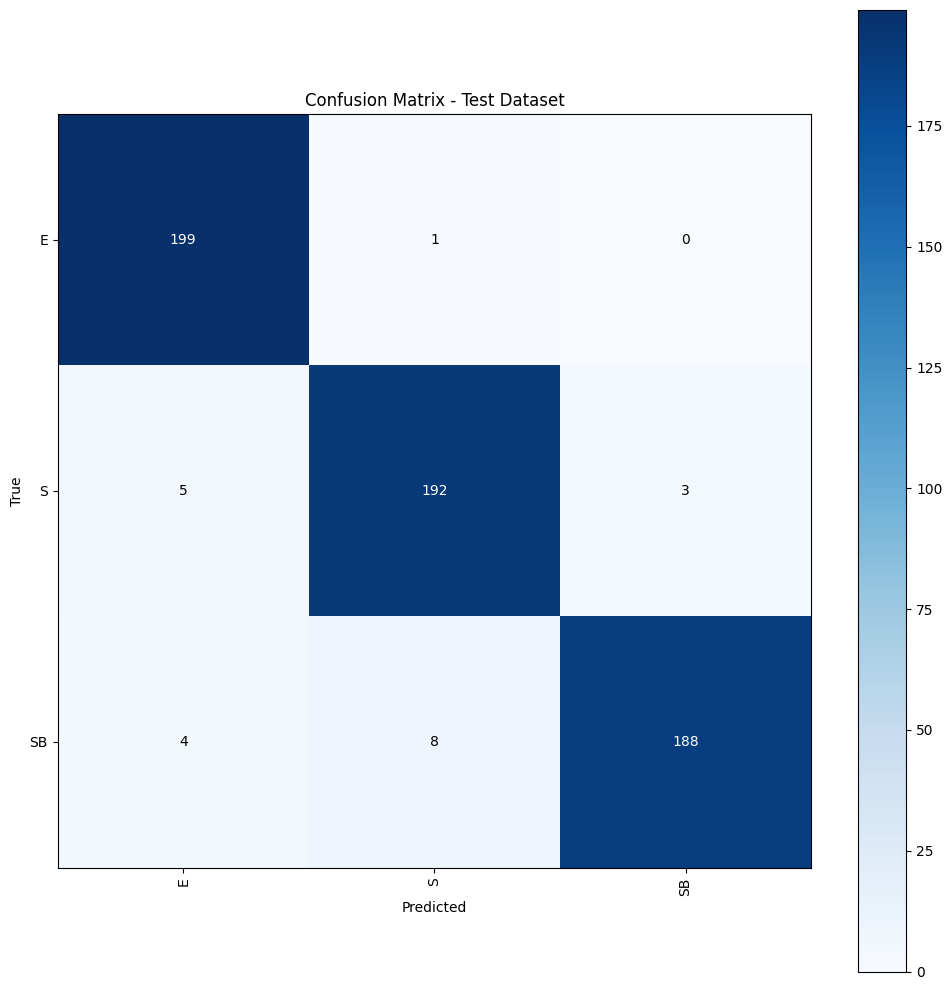

In [ ]:
evaluate_final_model(efficientnet_final_model_path, test_ds, class_names);

# Alternative way to load the model directly from the known path
# evaluate_final_model("./HubbleSimple_EfficientNet.keras", test_ds, class_names);

### ResNet50

Create the base model using the ResNet50 with pre-trained weights from the ImageNet dataset

In [21]:
resnet_base_model_fn = lambda : tf.keras.applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False, # Don't include the ImageNet classifier
    weights='imagenet' # Use pre-trained ImageNet weights
)
resnet_base_model_preprocessing_fn = lambda : tf.keras.applications.resnet.preprocess_input

resnet_model_name = "HubbleSimple_ResNet50"

Perform the hyperparameter optimization using optuna

In [22]:

# Set up cross-validation splits
resnet_kfold_cv = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

# Create an Optuna study and run the optimization
# The direction is 'minimize' because the loss is being minimized
study = optuna.create_study(direction='minimize')
objective = partial(optuna_objective, X_data = train_paths, y_data = train_labels, KFold_split = resnet_kfold_cv,
                    base_model_fn=resnet_base_model_fn, base_model_preprocessing_fn=resnet_base_model_preprocessing_fn, model_name=resnet_model_name,
                    num_classes=num_classes, train_weights=train_weights)
study.optimize(objective, n_trials=OPTUNA_TRIALS) # Set the number of trials for the search
print(f"Best parameters found: {study.best_params}")

[I 2025-12-06 14:23:15,593] A new study created in memory with name: no-name-a558989c-1bfe-452b-bff9-0a8baed4751e



Trial: 0, Parameters: {'num_layers': 2, 'neurons': 136, 'dropout_rate': 0.4, 'l1_alpha': 0.001, 'l2_alpha': 0.0, 'activation': 'leaky_relu'}, Learning Rate: 0.0020047532187779287


2025-12-06 14:23:27.235735: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


    Fold: 1, Loss: 1.2393231391906738, Accuracy: 0.9371428489685059, F1_score: 0.936271607875824
    Fold: 2, Loss: 0.2627094089984894, Accuracy: 0.9785714149475098, F1_score: 0.9785551428794861
    Fold: 3, Loss: 0.3666715919971466, Accuracy: 0.9657142758369446, F1_score: 0.9656853675842285


[I 2025-12-06 14:43:09,131] Trial 0 finished with value: 0.6229013800621033 and parameters: {'num_layers': 2, 'neurons': 136, 'dropout_rate': 0.4, 'l1_alpha': 0.001, 'l2_alpha': 0.0, 'activation': 'leaky_relu', 'learning_rate': 0.0020047532187779287}. Best is trial 0 with value: 0.6229013800621033.



Trial: 1, Parameters: {'num_layers': 2, 'neurons': 486, 'dropout_rate': 0.2, 'l1_alpha': 0.0, 'l2_alpha': 0.0, 'activation': 'relu'}, Learning Rate: 0.001130947160518531
    Fold: 1, Loss: 0.09691189229488373, Accuracy: 0.9685714244842529, F1_score: 0.9684938788414001
    Fold: 2, Loss: 0.15137332677841187, Accuracy: 0.9557142853736877, F1_score: 0.9556652903556824
    Fold: 3, Loss: 0.11128119379281998, Accuracy: 0.9642857313156128, F1_score: 0.9641723036766052


[I 2025-12-06 15:07:50,337] Trial 1 finished with value: 0.11985547095537186 and parameters: {'num_layers': 2, 'neurons': 486, 'dropout_rate': 0.2, 'l1_alpha': 0.0, 'l2_alpha': 0.0, 'activation': 'relu', 'learning_rate': 0.001130947160518531}. Best is trial 1 with value: 0.11985547095537186.



Trial: 2, Parameters: {'num_layers': 2, 'neurons': 366, 'dropout_rate': 0.4, 'l1_alpha': 0.0, 'l2_alpha': 0.0, 'activation': 'leaky_relu'}, Learning Rate: 0.0013539329908774018
    Fold: 1, Loss: 0.08096442371606827, Accuracy: 0.9757142663002014, F1_score: 0.9757096767425537
    Fold: 2, Loss: 0.15095843374729156, Accuracy: 0.9585714340209961, F1_score: 0.958538830280304
    Fold: 3, Loss: 0.08827301859855652, Accuracy: 0.9757142663002014, F1_score: 0.9756706357002258


[I 2025-12-06 15:33:30,730] Trial 2 finished with value: 0.10673195868730545 and parameters: {'num_layers': 2, 'neurons': 366, 'dropout_rate': 0.4, 'l1_alpha': 0.0, 'l2_alpha': 0.0, 'activation': 'leaky_relu', 'learning_rate': 0.0013539329908774018}. Best is trial 2 with value: 0.10673195868730545.



Trial: 3, Parameters: {'num_layers': 2, 'neurons': 472, 'dropout_rate': 0.2, 'l1_alpha': 0.001, 'l2_alpha': 0.0, 'activation': 'leaky_relu'}, Learning Rate: 0.002809166966227008
    Fold: 1, Loss: 0.1847902536392212, Accuracy: 0.9828571677207947, F1_score: 0.9828440546989441
    Fold: 2, Loss: 0.20485657453536987, Accuracy: 0.9714285731315613, F1_score: 0.9713552594184875
    Fold: 3, Loss: 0.14970217645168304, Accuracy: 0.9785714149475098, F1_score: 0.9785647392272949


[I 2025-12-06 16:00:35,351] Trial 3 finished with value: 0.17978300154209137 and parameters: {'num_layers': 2, 'neurons': 472, 'dropout_rate': 0.2, 'l1_alpha': 0.001, 'l2_alpha': 0.0, 'activation': 'leaky_relu', 'learning_rate': 0.002809166966227008}. Best is trial 2 with value: 0.10673195868730545.


Best parameters found: {'num_layers': 2, 'neurons': 366, 'dropout_rate': 0.4, 'l1_alpha': 0.0, 'l2_alpha': 0.0, 'activation': 'leaky_relu', 'learning_rate': 0.0013539329908774018}


Train the final model with the best hyperparameters found

Model: "HubbleSimple_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_aug            │ (None, 150, 150,  │          0 │ input_layer_40[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_39         │ (None, 150, 150)  │          0 │ data_aug[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_40         │ (None, 150, 150)  │          0 │ data_aug[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_41         │ (None, 150, 150)  │          0 │ data_aug[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_13 (Stack)    │ (None, 150, 150,  │          0 │ get_item_39[0][0… │
│                     │ 3)                │            │ get_item_40[0][0… │
│                     │                   │            │ get_item_41[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 150, 150,  │          0 │ stack_13[0][0]    │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 5, 5,      │ 23,587,712 │ add_13[0][0]      │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 2048)      │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 366)       │    749,934 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 366)       │          0 │ dense_39[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 183)       │     67,161 │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 183)       │          0 │ dense_40[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 3)         │        552 │ dropout_41[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,405,359 (93.10 MB)

 Trainable params: 817,647 (3.12 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Training the new layers...
Epoch 1/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - F1_score: 0.6739 - acc: 0.6752 - loss: 0.8422 - val_F1_score: 0.7814 - val_acc: 0.7967 - val_loss: 0.4541 - learning_rate: 0.0014
Epoch 2/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - F1_score: 0.7686 - acc: 0.7695 - loss: 0.5601 - val_F1_score: 0.8377 - val_acc: 0.8433 - val_loss: 0.3642 - learning_rate: 0.0014
Epoch 3/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - F1_score: 0.7899 - acc: 0.7910 - loss: 0.5176 - val_F1_score: 0.8150 - val_acc: 0.8200 - val_loss: 0.3998 - learning_rate: 0.0014
Epoch 4/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - F1_score: 0.8105 - acc: 0.8114 - loss: 0.4761 - val_F1_score: 0.8339 - val_acc: 0.8367 - val_loss: 0.3919 - learning_rate: 0.0014
Epoch 5/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - F1_score: 0.8209 - acc: 0.8210 - loss: 0.4365 - val_F1_score: 0.8377 - val_acc: 0.8400 - val_loss: 0.3315 - learning_rate: 0.0014
Epoch 6/150
132/132 ━━━━━━━━━━━━━━━━━━━━ 

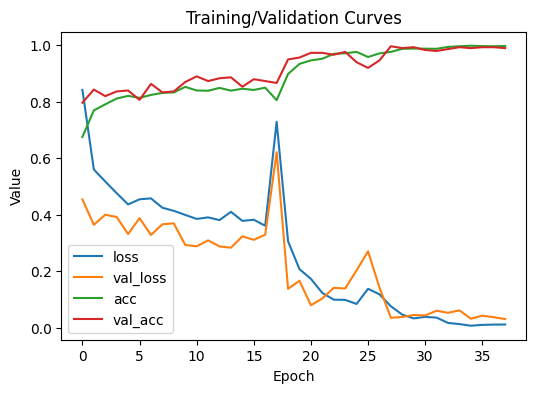

Final model saved at: ./HubbleSimple_ResNet50.keras


In [25]:
best_params = study.best_params

resnet_final_model, resnet_history, resnet_final_model_path = train_final_model(best_params, train_ds, val_ds,
                                                                                resnet_base_model_fn, resnet_base_model_preprocessing_fn, resnet_model_name, 
                                                                                num_classes, train_weights)

Evaluate the final model trained with the best hyperparameters

Model loaded successfully: ./HubbleSimple_ResNet50.keras

[Metrics - Test Dataset]
loss: 0.0634
compile_metrics: 0.9767


2025-12-06 16:40:19.011657: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



[Classification Report - Test Dataset]
              precision    recall  f1-score   support

           E       0.98      1.00      0.99       200
           S       0.97      0.97      0.97       200
          SB       0.99      0.95      0.97       200

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



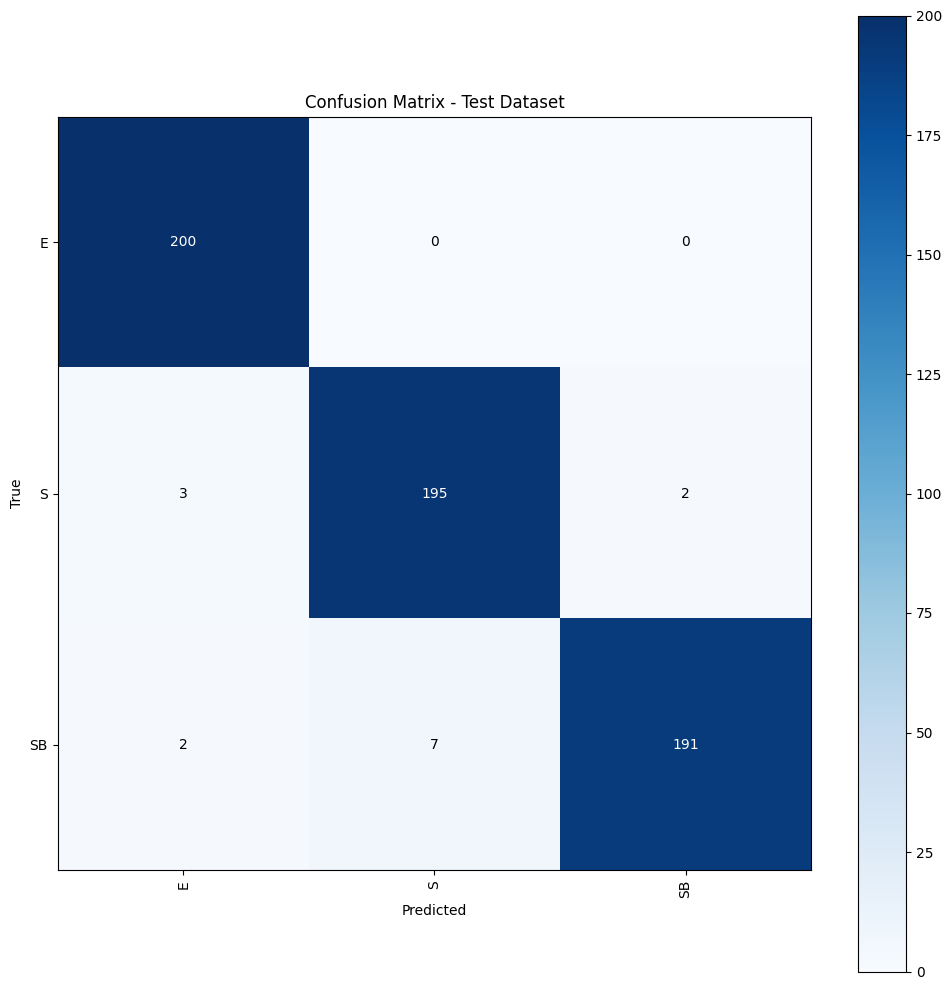

In [ ]:
evaluate_final_model(resnet_final_model_path, test_ds, class_names);

# Alternative way to load the model directly from the known path
# evaluate_final_model("./HubbleSimple_ResNet50.keras", test_ds, class_names);

## Scheme: hubble_classic
- ### Classes: E0, E3, E7, S0, Sa, Sb, Sc, SBa, SBb, SBc

Generate class labels based on hubble_classic scheme

In [16]:
labels, class_names, num_classes = get_labels('hubble_classic')


Creating labels with scheme: hubble_classic

Class distribution:
  Class -1 (Discarded): 232690 ( 95.6%)
  Class 0 (E0   ):   1381 (  0.6%)
  Class 1 (E3   ):   1065 (  0.4%)
  Class 2 (E7   ):   1034 (  0.4%)
  Class 3 (S0   ):   1006 (  0.4%)
  Class 4 (Sa   ):   1047 (  0.4%)
  Class 5 (Sb   ):   1036 (  0.4%)
  Class 6 (Sc   ):   1027 (  0.4%)
  Class 7 (SBa  ):   1051 (  0.4%)
  Class 8 (SBb  ):   1075 (  0.4%)
  Class 9 (SBc  ):   1088 (  0.4%)


Get the mapping between each filepath and label

In [17]:
image_paths, valid_labels = load_labels_mapping(labels)


Loading 243500 images...


Carregando: 100%|██████████| 243500/243500 [00:37<00:00, 6463.73it/s]


Loading results
Successfully loaded: 10810 images
Invalid class discarded (-1): 232690
ID not found in mapping: 0
File not found: 0
Error loading: 0


Generate the stratified train/validation/test datasets

In [18]:
train_paths, train_labels, val_paths, val_labels, test_paths, test_labels, train_weights = create_datasets(image_paths, valid_labels, class_names)

Class counts before balancing:
  Class 0 (E0 ): 1381
  Class 1 (E3 ): 1065
  Class 2 (E7 ): 1034
  Class 3 (S0 ): 1006
  Class 4 (Sa ): 1047
  Class 5 (Sb ): 1036
  Class 6 (Sc ): 1027
  Class 7 (SBa): 1051
  Class 8 (SBb): 1075
  Class 9 (SBc): 1088

Target sample size per class: 1000

Undersampling strategy (class: target_count):
  Class 0 (E0 ): 1000
  Class 1 (E3 ): 1000
  Class 2 (E7 ): 1000
  Class 3 (S0 ): 1000
  Class 4 (Sa ): 1000
  Class 5 (Sb ): 1000
  Class 6 (Sc ): 1000
  Class 7 (SBa): 1000
  Class 8 (SBb): 1000
  Class 9 (SBc): 1000

Dataset after balancing:
  Class 0 (E0 ): 1000
  Class 1 (E3 ): 1000
  Class 2 (E7 ): 1000
  Class 3 (S0 ): 1000
  Class 4 (Sa ): 1000
  Class 5 (Sb ): 1000
  Class 6 (Sc ): 1000
  Class 7 (SBa): 1000
  Class 8 (SBb): 1000
  Class 9 (SBc): 1000
Train Samples: 7000
Validation Samples: 1000
Test Samples: 2000

Class distribution (Train):
  Class 0 (E0 ):    700 ( 10.0%)
  Class 1 (E3 ):    700 ( 10.0%)
  Class 2 (E7 ):    700 ( 10.0%)
  Class 

Generate the final train/validation/test datasets compatible with tensorflow

In [19]:
train_ds, val_ds, test_ds = create_tf_datasets(train_paths, train_labels,
                                               val_paths, val_labels,
                                               test_paths, test_labels,
                                               num_classes)

I0000 00:00:1765108537.846219     841 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6100 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


Show some samples from each class

2025-12-07 09:02:05.901189: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


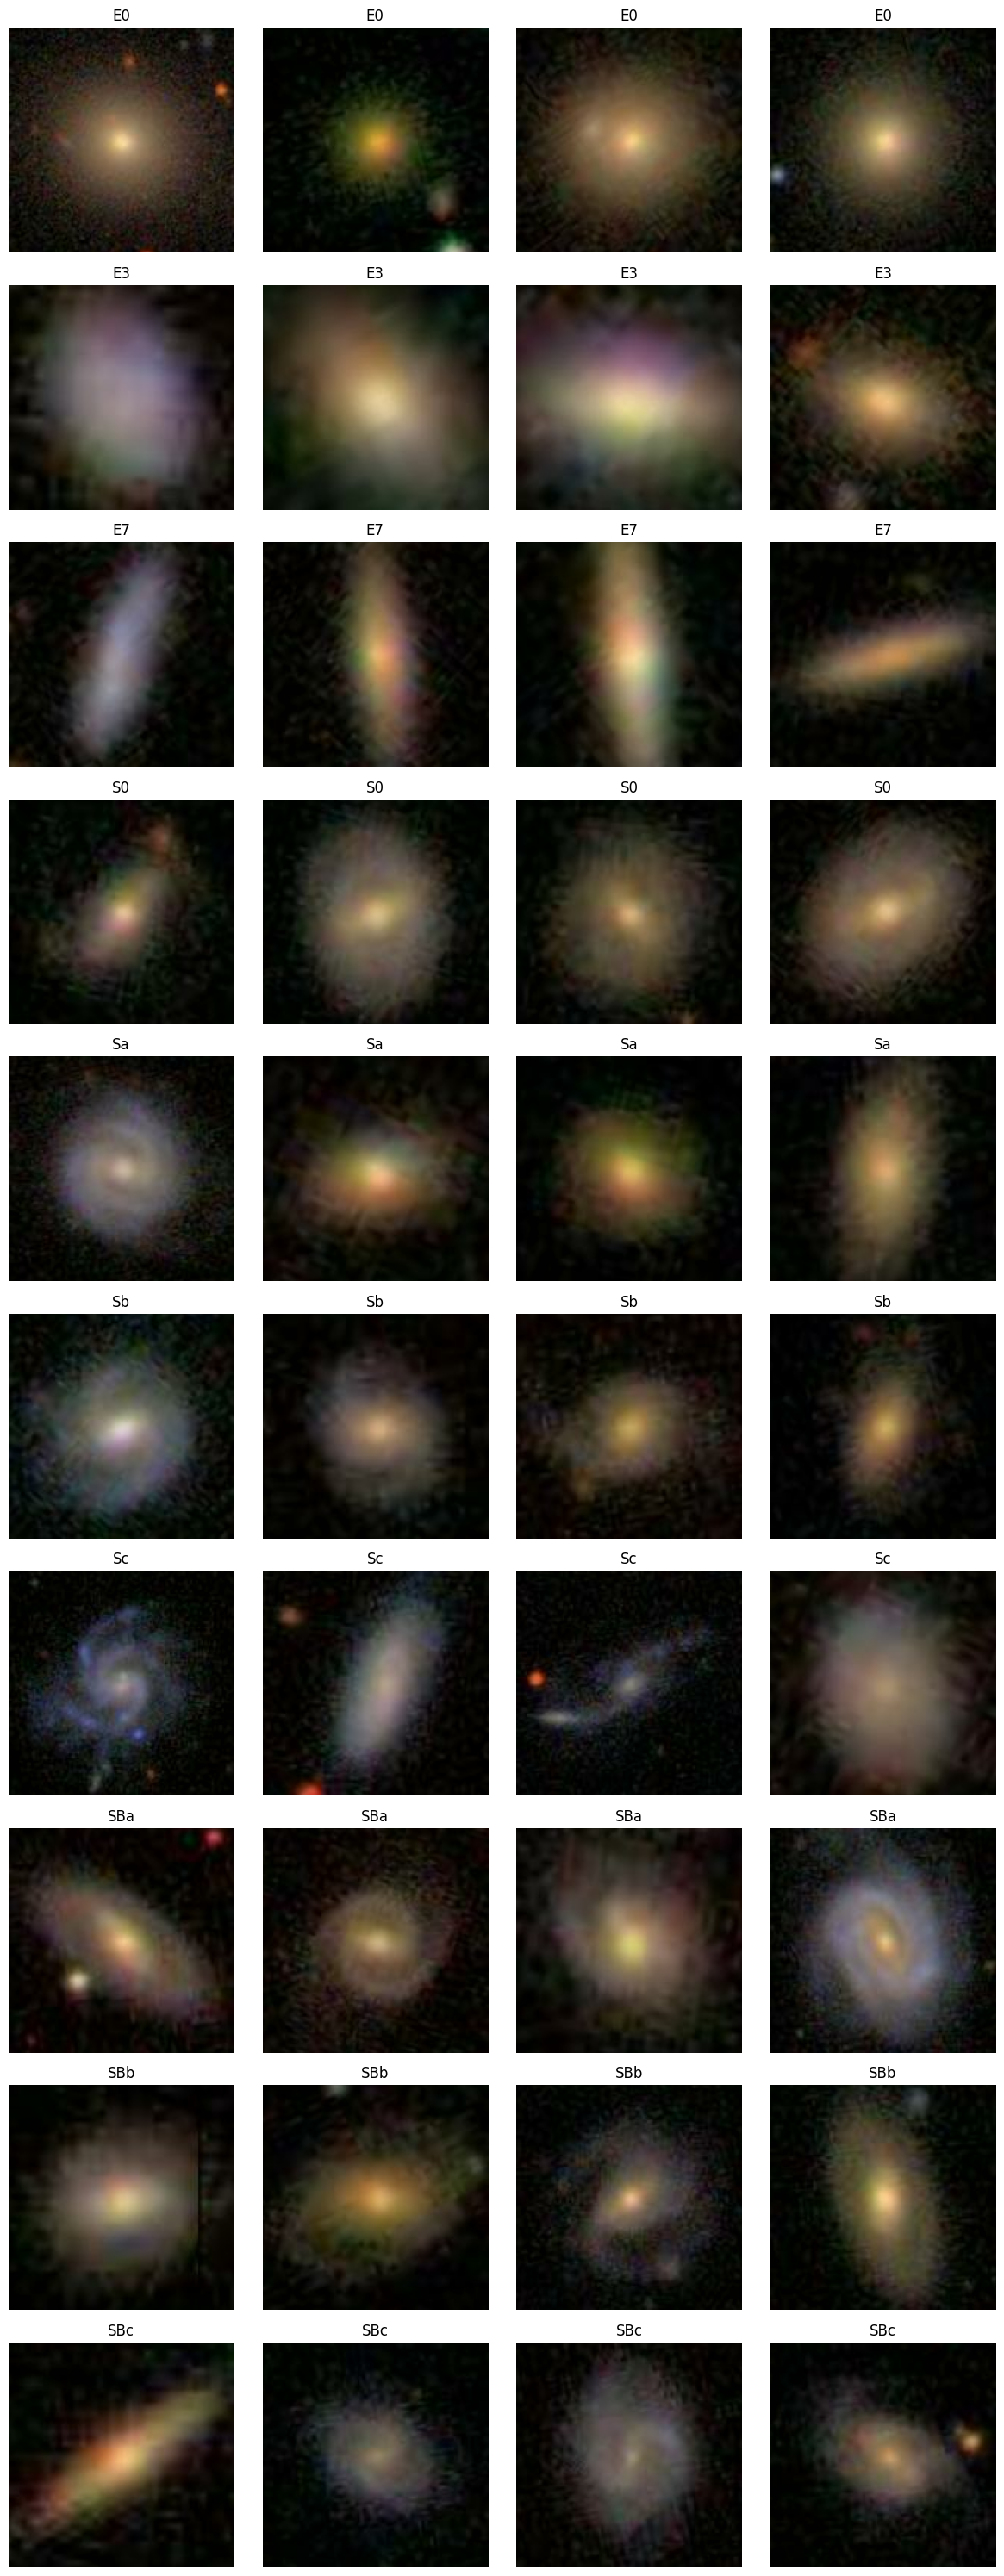

In [30]:
show_samples_per_class(train_ds, class_names, samples_per_class=4)

### Now, two different base models will be tested for the hubble_classic scheme: EfficientNetB3 and ResNet50

### EfficientNetB3

Create the base model using the EfficientNetB3 with pre-trained weights from the ImageNet dataset

In [21]:
efficientnet_base_model_fn = lambda : tf.keras.applications.EfficientNetB3(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False, # Don't include the ImageNet classifier
    weights='imagenet' # Use pre-trained ImageNet weights
)
efficientnet_base_model_preprocessing_fn = lambda : tf.keras.applications.efficientnet.preprocess_input

efficientnet_model_name = "HubbleClassic_EfficientNetB3"

Perform the hyperparameter optimization using optuna

In [22]:
# Set up cross-validation splits
efficientnet_kfold_cv = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

# Create an Optuna study and run the optimization
# The direction is 'minimize' because the loss is being minimized
study = optuna.create_study(direction='minimize')
objective = partial(optuna_objective, X_data = train_paths, y_data = train_labels, KFold_split = efficientnet_kfold_cv,
                    base_model_fn=efficientnet_base_model_fn, base_model_preprocessing_fn=efficientnet_base_model_preprocessing_fn, model_name=efficientnet_model_name,
                    num_classes=num_classes, train_weights=train_weights)
study.optimize(objective, n_trials=OPTUNA_TRIALS) # Set the number of trials for the search
print(f"Best parameters found: {study.best_params}")

[I 2025-12-05 21:39:41,599] A new study created in memory with name: no-name-b4c9a2e7-9c50-4fb5-84c4-4feb3ee4fcd0



Trial: 0, Parameters: {'num_layers': 2, 'neurons': 272, 'dropout_rate': 0.4, 'l1_alpha': 0.001, 'l2_alpha': 0.001, 'activation': 'relu'}, Learning Rate: 0.0014741802378372049


E0000 00:00:1764981596.897331  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-12-05 21:40:01.130329: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
E0000 00:00:1764981979.763613  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 1, Loss: 1.3639079332351685, Accuracy: 0.6311054229736328, F1_score: 0.6162561178207397


E0000 00:00:1764984720.162676  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1764984935.119939  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 2, Loss: 1.3824471235275269, Accuracy: 0.622803270816803, F1_score: 0.6110256910324097


E0000 00:00:1764987044.152046  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1764987281.445559  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 3, Loss: 1.4238446950912476, Accuracy: 0.597942590713501, F1_score: 0.5766540765762329


[I 2025-12-05 23:44:13,950] Trial 0 finished with value: 1.3900665839513142 and parameters: {'num_layers': 2, 'neurons': 272, 'dropout_rate': 0.4, 'l1_alpha': 0.001, 'l2_alpha': 0.001, 'activation': 'relu', 'learning_rate': 0.0014741802378372049}. Best is trial 0 with value: 1.3900665839513142.



Trial: 1, Parameters: {'num_layers': 1, 'neurons': 218, 'dropout_rate': 0.4, 'l1_alpha': 0.0, 'l2_alpha': 0.001, 'activation': 'relu'}, Learning Rate: 0.0015401466620702465


E0000 00:00:1764989067.174570  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1764989425.559770  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 1, Loss: 1.3998677730560303, Accuracy: 0.6345329880714417, F1_score: 0.6233285665512085


E0000 00:00:1764992566.962499  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1764992970.283038  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 2, Loss: 1.2917977571487427, Accuracy: 0.6180883049964905, F1_score: 0.6028863787651062


E0000 00:00:1764994647.203043  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1764994876.206891  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 3, Loss: 1.1923075914382935, Accuracy: 0.6223746538162231, F1_score: 0.6095130443572998


[I 2025-12-06 01:46:22,125] Trial 1 finished with value: 1.2946577072143555 and parameters: {'num_layers': 1, 'neurons': 218, 'dropout_rate': 0.4, 'l1_alpha': 0.0, 'l2_alpha': 0.001, 'activation': 'relu', 'learning_rate': 0.0015401466620702465}. Best is trial 1 with value: 1.2946577072143555.



Trial: 2, Parameters: {'num_layers': 2, 'neurons': 234, 'dropout_rate': 0.2, 'l1_alpha': 0.001, 'l2_alpha': 0.0, 'activation': 'leaky_relu'}, Learning Rate: 0.004990330044529943


E0000 00:00:1764996395.837582  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1764996652.344753  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 1, Loss: 1.2622870206832886, Accuracy: 0.6580976843833923, F1_score: 0.6455573439598083


E0000 00:00:1764999176.407065  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1764999378.046399  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 2, Loss: 1.366745948791504, Accuracy: 0.6480925679206848, F1_score: 0.6392892599105835


E0000 00:00:1765002255.779233  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1765002452.386036  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 3, Loss: 1.2284153699874878, Accuracy: 0.6699528694152832, F1_score: 0.6636568307876587


[I 2025-12-06 04:06:54,426] Trial 2 finished with value: 1.2858161131540935 and parameters: {'num_layers': 2, 'neurons': 234, 'dropout_rate': 0.2, 'l1_alpha': 0.001, 'l2_alpha': 0.0, 'activation': 'leaky_relu', 'learning_rate': 0.004990330044529943}. Best is trial 2 with value: 1.2858161131540935.



Trial: 3, Parameters: {'num_layers': 2, 'neurons': 226, 'dropout_rate': 0.4, 'l1_alpha': 0.001, 'l2_alpha': 0.0, 'activation': 'leaky_relu'}, Learning Rate: 0.0012762795255974073


E0000 00:00:1765004828.046301  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1765005114.292404  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 1, Loss: 1.3023829460144043, Accuracy: 0.6495286822319031, F1_score: 0.6403247117996216


E0000 00:00:1765008231.852045  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1765008412.534810  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 2, Loss: 1.663096308708191, Accuracy: 0.6326618194580078, F1_score: 0.620932936668396


E0000 00:00:1765011086.447995  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1765011353.510482  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    Fold: 3, Loss: 1.2473682165145874, Accuracy: 0.6528075337409973, F1_score: 0.6426451206207275


[I 2025-12-06 06:37:47,153] Trial 3 finished with value: 1.4042824904123943 and parameters: {'num_layers': 2, 'neurons': 226, 'dropout_rate': 0.4, 'l1_alpha': 0.001, 'l2_alpha': 0.0, 'activation': 'leaky_relu', 'learning_rate': 0.0012762795255974073}. Best is trial 2 with value: 1.2858161131540935.


Best parameters found: {'num_layers': 2, 'neurons': 234, 'dropout_rate': 0.2, 'l1_alpha': 0.001, 'l2_alpha': 0.0, 'activation': 'leaky_relu', 'learning_rate': 0.004990330044529943}


Train the final model with the best hyperparameters found

Model: "HubbleClassic_EfficientNetB3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_aug (Sequential)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 5, 5, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 234)            │       359,658 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 234)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 117)            │        27,495 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 117)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 10)             │         1,180 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,868 (42.62 MB)

 Trainable params: 388,333 (1.48 MB)

 Non-trainable params: 10,783,535 (41.14 MB)


Training the new layers...
Epoch 1/150


E0000 00:00:1765013881.765178  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


438/438 ━━━━━━━━━━━━━━━━━━━━ 57s 99ms/step - F1_score: 0.2857 - acc: 0.3093 - loss: 3.6502 - val_F1_score: 0.3005 - val_acc: 0.3670 - val_loss: 2.4214 - learning_rate: 0.0050
Epoch 2/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - F1_score: 0.3045 - acc: 0.3306 - loss: 2.4216 - val_F1_score: 0.3206 - val_acc: 0.3670 - val_loss: 2.2970 - learning_rate: 0.0050
Epoch 3/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - F1_score: 0.3117 - acc: 0.3369 - loss: 2.3674 - val_F1_score: 0.2791 - val_acc: 0.3560 - val_loss: 2.2708 - learning_rate: 0.0050
Epoch 4/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - F1_score: 0.3035 - acc: 0.3291 - loss: 2.3927 - val_F1_score: 0.3089 - val_acc: 0.3740 - val_loss: 2.2494 - learning_rate: 0.0050
Epoch 5/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - F1_score: 0.3224 - acc: 0.3451 - loss: 2.3762 - val_F1_score: 0.3052 - val_acc: 0.3740 - val_loss: 2.3141 - learning_rate: 0.0050
Epoch 6/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - F1_score: 0.3178 - a

E0000 00:00:1765014941.667809  135822 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/HubbleClassic_EfficientNetB3_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


438/438 ━━━━━━━━━━━━━━━━━━━━ 249s 443ms/step - F1_score: 0.3626 - acc: 0.3907 - loss: 1.8456 - val_F1_score: 0.4483 - val_acc: 0.4870 - val_loss: 1.5257 - learning_rate: 4.9903e-04
Epoch 27/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 195s 446ms/step - F1_score: 0.4575 - acc: 0.4790 - loss: 1.6019 - val_F1_score: 0.4934 - val_acc: 0.5270 - val_loss: 1.3889 - learning_rate: 4.9903e-04
Epoch 28/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 191s 437ms/step - F1_score: 0.5095 - acc: 0.5246 - loss: 1.4639 - val_F1_score: 0.5296 - val_acc: 0.5490 - val_loss: 1.3870 - learning_rate: 4.9903e-04
Epoch 29/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 193s 441ms/step - F1_score: 0.5482 - acc: 0.5589 - loss: 1.3853 - val_F1_score: 0.4923 - val_acc: 0.5380 - val_loss: 1.5149 - learning_rate: 4.9903e-04
Epoch 30/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 201s 458ms/step - F1_score: 0.5650 - acc: 0.5764 - loss: 1.3491 - val_F1_score: 0.5457 - val_acc: 0.5710 - val_loss: 1.3474 - learning_rate: 4.9903e-04
Epoch 31/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 2

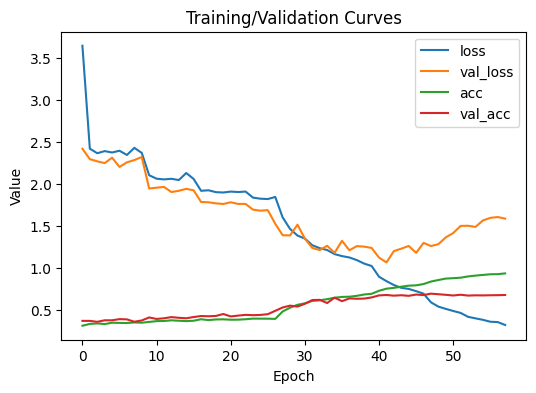

Final model saved at: ./HubbleClassic_EfficientNetB3.keras


In [23]:
best_params = study.best_params

efficientnet_final_model, efficientnet_history, efficientnet_final_model_path = train_final_model(best_params, train_ds, val_ds,
                                                                                                  efficientnet_base_model_fn, efficientnet_base_model_preprocessing_fn, efficientnet_model_name,
                                                                                                  num_classes, train_weights)

Evaluate the final model trained with the best hyperparameters

Model loaded successfully: ./HubbleClassic_EfficientNetB3.keras

[Metrics - Test Dataset]
loss: 1.2158
compile_metrics: 0.6740


2025-12-06 08:40:00.733719: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



[Classification Report - Test Dataset]
              precision    recall  f1-score   support

          E0       0.90      0.98      0.94       200
          E3       0.81      0.97      0.88       200
          E7       0.87      0.97      0.92       200
          S0       0.57      0.62      0.60       200
          Sa       0.51      0.50      0.50       200
          Sb       0.55      0.40      0.46       200
          Sc       0.59      0.69      0.64       200
         SBa       0.57      0.36      0.45       200
         SBb       0.61      0.54      0.57       200
         SBc       0.63      0.69      0.66       200

    accuracy                           0.67      2000
   macro avg       0.66      0.67      0.66      2000
weighted avg       0.66      0.67      0.66      2000



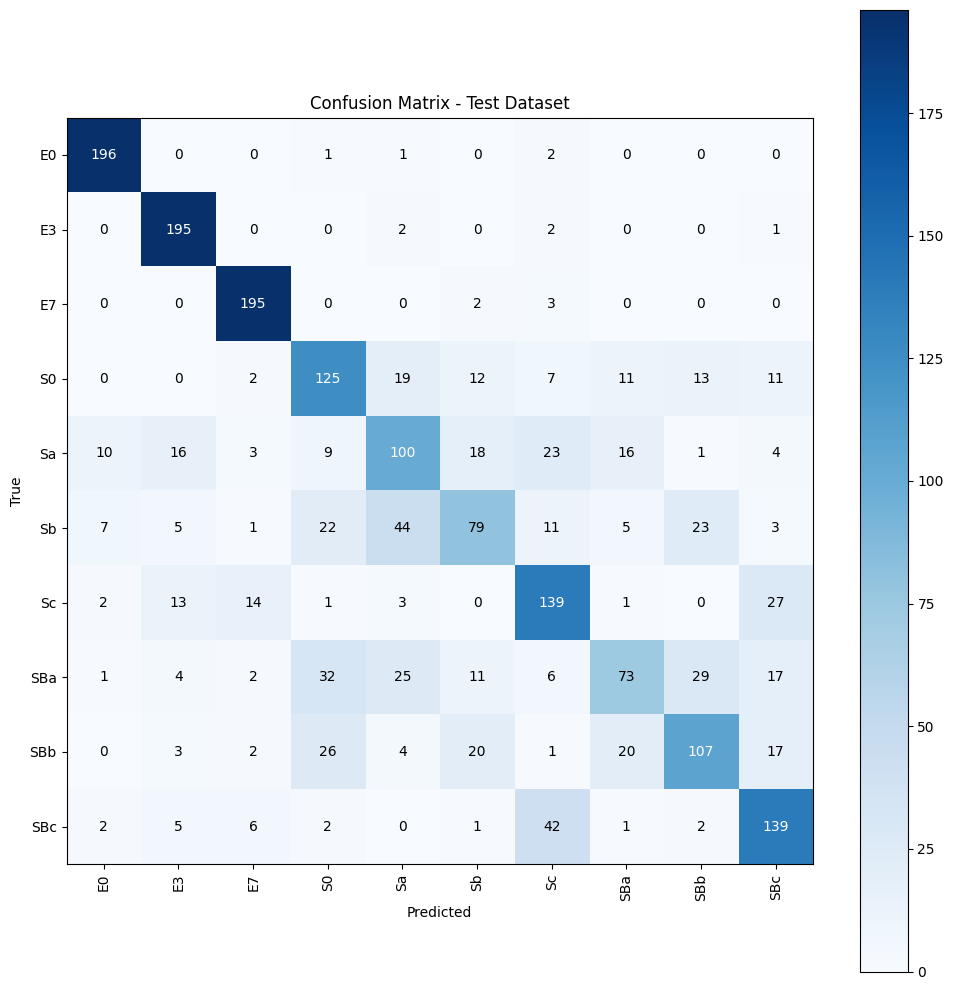

In [ ]:
evaluate_final_model(efficientnet_final_model_path, test_ds, class_names);

# Alternative way to load the model directly from the known path
# evaluate_final_model("./HubbleClassic_EfficientNet.keras", test_ds, class_names);

### ResNet50

Create the base model using the ResNet50 with pre-trained weights from the ImageNet dataset

In [21]:
resnet_base_model_fn = lambda : tf.keras.applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False, # Don't include the ImageNet classifier
    weights='imagenet' # Use pre-trained ImageNet weights
)
resnet_base_model_preprocessing_fn = lambda : tf.keras.applications.resnet.preprocess_input

resnet_model_name = "HubbleClassic_ResNet50"

Perform the hyperparameter optimization using optuna

In [ ]:
# Set up cross-validation splits
resnet_kfold_cv = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

# Create an Optuna study and run the optimization
# The direction is 'minimize' because the loss is being minimized
study = optuna.create_study(direction='minimize')
objective = partial(optuna_objective, X_data = train_paths, y_data = train_labels, KFold_split = resnet_kfold_cv,
                    base_model_fn=resnet_base_model_fn, base_model_preprocessing_fn=resnet_base_model_preprocessing_fn, model_name=resnet_model_name,
                    num_classes=num_classes, train_weights=train_weights)
study.optimize(objective, n_trials=OPTUNA_TRIALS) # Set the number of trials for the search
print(f"Best parameters found: {study.best_params}")

[I 2025-12-07 02:27:14,657] A new study created in memory with name: no-name-0edb9840-74eb-4d3f-ae3e-568a8c844171



Trial: 0, Parameters: {'num_layers': 1, 'neurons': 256, 'dropout_rate': 0.4, 'l1_alpha': 0.001, 'l2_alpha': 0.001, 'activation': 'relu'}, Learning Rate: 0.0030730836487553566


2025-12-07 02:27:28.445174: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


    Fold: 1, Loss: 1.1928473711013794, Accuracy: 0.6539903879165649, F1_score: 0.6421875953674316
    Fold: 2, Loss: 1.0599712133407593, Accuracy: 0.6786288022994995, F1_score: 0.6696746349334717
    Fold: 3, Loss: 1.1759343147277832, Accuracy: 0.6538049578666687, F1_score: 0.6425052881240845


[I 2025-12-07 03:53:24,703] Trial 0 finished with value: 1.1429176330566406 and parameters: {'num_layers': 1, 'neurons': 256, 'dropout_rate': 0.4, 'l1_alpha': 0.001, 'l2_alpha': 0.001, 'activation': 'relu', 'learning_rate': 0.0030730836487553566}. Best is trial 0 with value: 1.1429176330566406.



Trial: 1, Parameters: {'num_layers': 2, 'neurons': 154, 'dropout_rate': 0.4, 'l1_alpha': 0.0, 'l2_alpha': 0.0, 'activation': 'relu'}, Learning Rate: 0.001226256348938236
    Fold: 1, Loss: 1.2154065370559692, Accuracy: 0.6518478989601135, F1_score: 0.6390612125396729
    Fold: 2, Loss: 1.0969042778015137, Accuracy: 0.6545259952545166, F1_score: 0.639407753944397
    Fold: 3, Loss: 1.1789063215255737, Accuracy: 0.5723472833633423, F1_score: 0.5513778924942017


[I 2025-12-07 05:08:35,944] Trial 1 finished with value: 1.1637390454610188 and parameters: {'num_layers': 2, 'neurons': 154, 'dropout_rate': 0.4, 'l1_alpha': 0.0, 'l2_alpha': 0.0, 'activation': 'relu', 'learning_rate': 0.001226256348938236}. Best is trial 0 with value: 1.1429176330566406.



Trial: 2, Parameters: {'num_layers': 2, 'neurons': 172, 'dropout_rate': 0.4, 'l1_alpha': 0.0, 'l2_alpha': 0.0, 'activation': 'relu'}, Learning Rate: 0.0034869633437055003
    Fold: 1, Loss: 1.1933934688568115, Accuracy: 0.6025709509849548, F1_score: 0.5853201150894165
    Fold: 2, Loss: 1.060191035270691, Accuracy: 0.6566684246063232, F1_score: 0.6455415487289429
    Fold: 3, Loss: 1.1999183893203735, Accuracy: 0.6184351444244385, F1_score: 0.6062135696411133


[I 2025-12-07 07:25:19,192] Trial 2 finished with value: 1.151167631149292 and parameters: {'num_layers': 2, 'neurons': 172, 'dropout_rate': 0.4, 'l1_alpha': 0.0, 'l2_alpha': 0.0, 'activation': 'relu', 'learning_rate': 0.0034869633437055003}. Best is trial 0 with value: 1.1429176330566406.



Trial: 3, Parameters: {'num_layers': 1, 'neurons': 144, 'dropout_rate': 0.3, 'l1_alpha': 0.0, 'l2_alpha': 0.0, 'activation': 'leaky_relu'}, Learning Rate: 0.0012817907269610208
    Fold: 1, Loss: 1.4650555849075317, Accuracy: 0.6448848247528076, F1_score: 0.630591094493866
    Fold: 2, Loss: 1.2158044576644897, Accuracy: 0.6416711211204529, F1_score: 0.6270196437835693
    Fold: 3, Loss: 1.3119652271270752, Accuracy: 0.6564844846725464, F1_score: 0.6444008350372314


[I 2025-12-07 08:38:19,657] Trial 3 finished with value: 1.3309417565663655 and parameters: {'num_layers': 1, 'neurons': 144, 'dropout_rate': 0.3, 'l1_alpha': 0.0, 'l2_alpha': 0.0, 'activation': 'leaky_relu', 'learning_rate': 0.0012817907269610208}. Best is trial 0 with value: 1.1429176330566406.


Best parameters found: {'num_layers': 1, 'neurons': 256, 'dropout_rate': 0.4, 'l1_alpha': 0.001, 'l2_alpha': 0.001, 'activation': 'relu', 'learning_rate': 0.0030730836487553566}


Train the final model with the best hyperparameters found

Model: "HubbleClassic_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_aug            │ (None, 150, 150,  │          0 │ input_layer_43[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_42         │ (None, 150, 150)  │          0 │ data_aug[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_43         │ (None, 150, 150)  │          0 │ data_aug[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_44         │ (None, 150, 150)  │          0 │ data_aug[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_14 (Stack)    │ (None, 150, 150,  │          0 │ get_item_42[0][0… │
│                     │ 3)                │            │ get_item_43[0][0… │
│                     │                   │            │ get_item_44[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 150, 150,  │          0 │ stack_14[0][0]    │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 5, 5,      │ 23,587,712 │ add_14[0][0]      │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 2048)      │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 256)       │    524,544 │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 256)       │          0 │ dense_36[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 10)        │      2,570 │ dropout_37[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Training the new layers...
Epoch 1/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - F1_score: 0.2897 - acc: 0.3089 - loss: 3.8820 - val_F1_score: 0.2791 - val_acc: 0.3350 - val_loss: 2.7614 - learning_rate: 0.0031
Epoch 2/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - F1_score: 0.3022 - acc: 0.3260 - loss: 2.7491 - val_F1_score: 0.3134 - val_acc: 0.3670 - val_loss: 2.4744 - learning_rate: 0.0031
Epoch 3/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - F1_score: 0.3050 - acc: 0.3281 - loss: 2.4995 - val_F1_score: 0.3428 - val_acc: 0.3720 - val_loss: 2.3530 - learning_rate: 0.0031
Epoch 4/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - F1_score: 0.3108 - acc: 0.3340 - loss: 2.5194 - val_F1_score: 0.2891 - val_acc: 0.3680 - val_loss: 2.2624 - learning_rate: 0.0031
Epoch 5/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - F1_score: 0.3125 - acc: 0.3363 - loss: 2.4434 - val_F1_score: 0.3178 - val_acc: 0.3710 - val_loss: 2.2416 - learning_rate: 0.0031
Epoch 6/150
438/438 ━━━━━━━━━━━━━━━━━

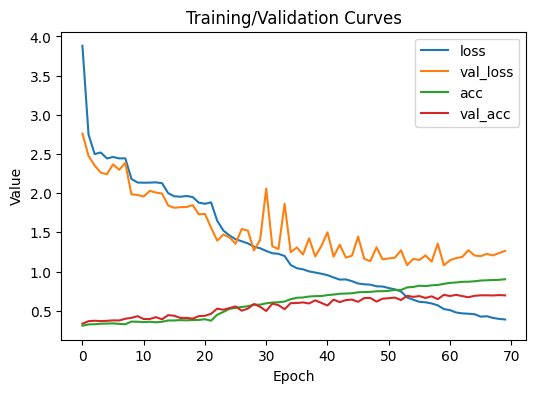

Final model saved at: ./HubbleClassic_ResNet50.keras


In [38]:
best_params = study.best_params

resnet_final_model, resnet_history, resnet_final_model_path = train_final_model(best_params, train_ds, val_ds,
                                                                                resnet_base_model_fn, resnet_base_model_preprocessing_fn, resnet_model_name, 
                                                                                num_classes, train_weights)

Evaluate the final model trained with the best hyperparameters

Model loaded successfully: ./HubbleClassic_ResNet50.keras

[Metrics - Test Dataset]
loss: 1.0983
compile_metrics: 0.7000

[Classification Report - Test Dataset]
              precision    recall  f1-score   support

          E0       0.90      0.95      0.93       200
          E3       0.86      0.94      0.90       200
          E7       0.87      0.99      0.93       200
          S0       0.57      0.68      0.62       200
          Sa       0.59      0.47      0.53       200
          Sb       0.54      0.50      0.52       200
          Sc       0.70      0.73      0.71       200
         SBa       0.66      0.47      0.55       200
         SBb       0.56      0.58      0.57       200
         SBc       0.68      0.68      0.68       200

    accuracy                           0.70      2000
   macro avg       0.69      0.70      0.69      2000
weighted avg       0.69      0.70      0.69      2000



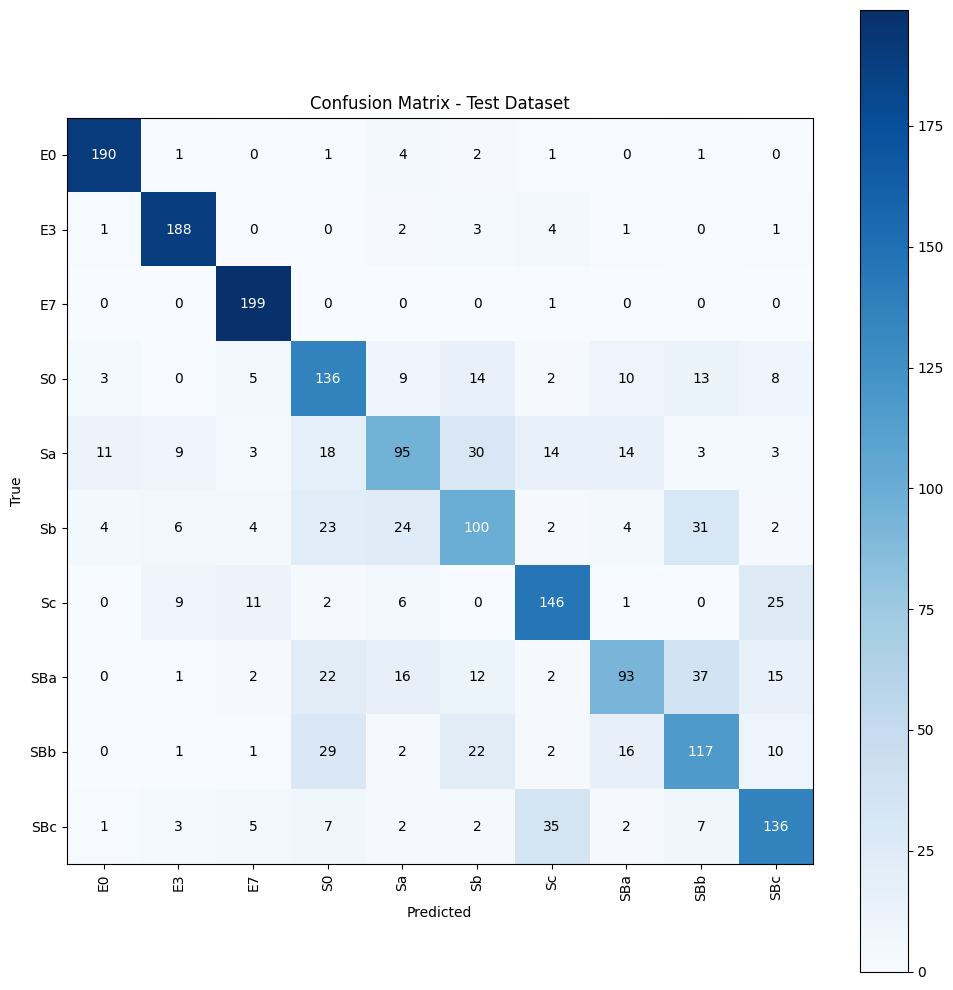

In [ ]:
evaluate_final_model(resnet_final_model_path, test_ds, class_names);

# Alternative way to load the model directly from the known path
# evaluate_final_model("./HubbleClassic_ResNet50.keras", test_ds, class_names);